In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Statments
--

In [ ]:
!pip install biopython # otherwise the data_prep_functions will not be imported!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 15.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/'
sys.path.append(data_prep_path)

from data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import pprint
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification # I think this is for synthetic datasets?
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE, RFECV, f_classif


Mounted at /content/drive
test!


Data Preparation
--


Linking to DataFrames(s) of interest

In [ ]:
# Specify input directory filepath
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/'

# Initialize an empty list to store Excel file paths
excel_files = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)
        # Append the file path to the list
        excel_files.append(file_path)

# Print the list of Excel file paths to verify proper list appending
print(excel_files)

['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/df_Bov Swiss Intensity.xlsx']


DataFrame Cleanup


*   Remove zeros and NaN
*   Replace with the second lowest found value for Abundance column



In [ ]:
# Iterate over each Excel file
for file in excel_files:
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    # Extract the filename without extension
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Specify the output file path with the current filename included
    output_file_path = os.path.join('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)

Initial Model Training & Important Features Determination
--
Initializing Standard Pipeline - Threaded

In [ ]:
# Specify input directory filepath
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs'

# Initialize an empty list to store Excel file paths
processed_files = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    # Check if the file is an Excel file
    if file.endswith('.xlsx'):
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)
        # Append the file path to the list
        processed_files.append(file_path)

# Print the list of Excel file paths to verify proper list appending
print(processed_files)

['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Top3.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss iBAQ.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_90_percent.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_10_percent.xlsx']


Make Train/Test Split; 90% Train, 10% Test, two Excel files

In [ ]:
# Load the CLEANED (above code cell) data from an Excel file into a pandas DataFrame
file_name = 'Bov SP Intensity'
data_file_path = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx'
data = pd.read_excel(data_file_path)

# Split the data into 90% for training and 10% for testing
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

# Specify the file paths where you want to save the Excel files
train_file_path = (f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_{file_name}.xlsx')
test_file_path = (f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_{file_name}.xlsx')

# Save the training data to the specified Excel file
train_data.to_excel(train_file_path, index=False)

# Save the test data to the specified Excel file
test_data.to_excel(test_file_path, index=False)

print(f"Train dataset saved to {train_file_path}")
print(f"Test dataset saved to {test_file_path}")

Train dataset saved to /content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_Bov SP Intensity.xlsx
Test dataset saved to /content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/test_data_Bov SP Intensity.xlsx


Specifying directory and files to be used in model

In [ ]:
# For shorter computing time, run one file at a time
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/'

# file_beginning = 'df_'
# file_group = 'Bov Swiss' # options are 'Bov Swiss', Ignore: 'Bov Swiss Tremble
# file_ending = ' Intensity.xlsx' # options are ' Intensity.xlsx', ' Top3.xlsx', ' iBAQ.xlsx'
# target_file = file_beginning + file_group + file_ending  # This constructs the exact target file name
files = []

target_file = 'train_data_Bov SP Intensity.xlsx'

for file in os.listdir(input_directory):
    if file == target_file:  # Use exact match instead of partial matches
        files.append(file)

print(files)

['train_data_Bov SP Intensity.xlsx']


Adding ANOVA evaluation

In [ ]:
def calculate_anova(X, y):
    f_values, p_values = f_classif(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
          'Abundance_Controls' : 'Protein Abundance in FBS',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_var': 'Flexibility - Variance',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'flexibility_median': 'Flexibility - Median',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_median': 'Relative Surface Area - Median',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_total_exposed_A': '% Exposed Amino Acid A / Total Amino Acids',
          'fraction_total_exposed_C': '% Exposed Amino Acid C / Total Amino Acids',
          'fraction_total_exposed_D': '% Exposed Amino Acid D / Total Amino Acids',
          'fraction_total_exposed_E': '% Exposed Amino Acid E / Total Amino Acids',
          'fraction_total_exposed_F': '% Exposed Amino Acid F / Total Amino Acids',
          'fraction_total_exposed_G': '% Exposed Amino Acid G / Total Amino Acids',
          'fraction_total_exposed_H': '% Exposed Amino Acid H / Total Amino Acids',
          'fraction_total_exposed_I': '% Exposed Amino Acid I / Total Amino Acids',
          'fraction_total_exposed_K': '% Exposed Amino Acid K / Total Amino Acids',
          'fraction_total_exposed_L': '% Exposed Amino Acid L / Total Amino Acids',
          'fraction_total_exposed_M': '% Exposed Amino Acid M / Total Amino Acids',
          'fraction_total_exposed_N': '% Exposed Amino Acid N / Total Amino Acids',
          'fraction_total_exposed_P': '% Exposed Amino Acid P / Total Amino Acids',
          'fraction_total_exposed_Q': '% Exposed Amino Acid Q / Total Amino Acids',
          'fraction_total_exposed_R': '% Exposed Amino Acid R / Total Amino Acids',
          'fraction_total_exposed_S': '% Exposed Amino Acid S / Total Amino Acids',
          'fraction_total_exposed_T': '% Exposed Amino Acid T / Total Amino Acids',
          'fraction_total_exposed_V': '% Exposed Amino Acid V / Total Amino Acids',
          'fraction_total_exposed_W': '% Exposed Amino Acid W / Total Amino Acids',
          'fraction_total_exposed_Y': '% Exposed Amino Acid Y / Total Amino Acids',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'asa_sum_normalized': 'Sum of Absolute Surface Area / Total Mass',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Zeta Potential': 'Zeta Potential',
          'Core Material': 'NP Core Material',
          'Surface_Ligand': 'Surface Functionalization',
          'Dtem': 'NP Diameter (TEM)',
          'Dh_functionalized': 'NP Diameter (hydrodynamic)',
          'NP_incubation Concentration (mg/mL)': 'NP Conc. (mg/mL)',
          'Incubation Concentration (mg/mL)': 'Protein Conc. (mg/mL)'
    }

    f_values, p_values = calculate_anova(X, y)
    # Replace feature_names with full names using the dictionary
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features


def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    #ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()


using 90 percent training data file

train_data_Bov SP Intensity
0    0.956057
1   -3.881778
2    5.717608
3    8.987216
4    6.575172
Name: Enrich, dtype: float64
0    0
1    0
2    1
3    1
4    1
Name: binary_target, dtype: int64
Best Features Names: ['Abundance_Controls', 'Length', 'Mass', 'frac_aa_C', 'frac_aa_F', 'frac_aa_G', 'frac_aa_I', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'molecular_weight', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_I', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_L

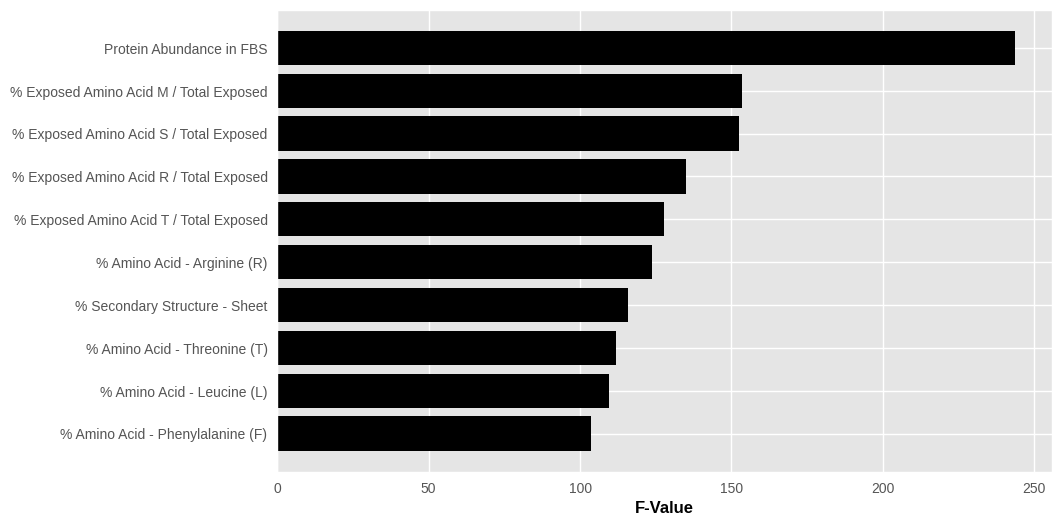

                                   Feature     F-Value       P-Value
0                 Protein Abundance in FBS  243.722958  7.260173e-53
25  % Exposed Amino Acid M / Total Exposed  153.343610  2.242546e-34
28  % Exposed Amino Acid S / Total Exposed  152.342412  3.621063e-34
27  % Exposed Amino Acid R / Total Exposed  135.075928  1.444178e-30
29  % Exposed Amino Acid T / Total Exposed  127.877388  4.652335e-29
9              % Amino Acid - Arginine (R)  123.730108  3.454458e-28
31           % Secondary Structure - Sheet  115.798292  1.612671e-26
11            % Amino Acid - Threonine (T)  112.000885  1.019807e-25
7               % Amino Acid - Leucine (L)  109.624679  3.238485e-25
4         % Amino Acid - Phenylalanine (F)  103.523053  6.326278e-24


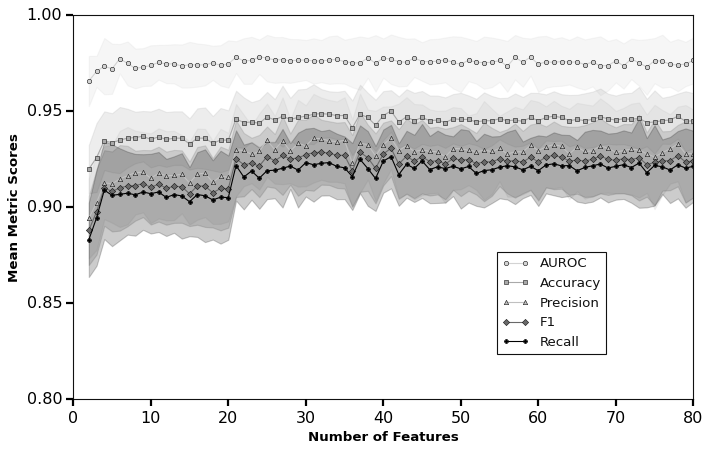

All files processed!


In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    #df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    #y_label = df['binary_target'].copy().values
    label_df = df['binary_target'].copy()

    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)


    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Accuracy": [],
                                    "Accuracy std": [],
                                    "Precision": [],
                                    "Precision std": [],
                                    "Recall": [],
                                    "Recall std": [],
                                    "F1": [],
                                    "F1 std": [],
                                    "AUROC": [],
                                    "AUROC std": [],
                                    "List of features": [],
                                    "Combined Score": []}
                                   )

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies, precisions, recalls, f1s, aurocs = [], [], [], [], []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

          # Evaluate on validation set
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Record the results
        # naming change 9/1
        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        # df_full_results.loc[len(df_full_results)] = {
        #     'Number of features': n_features,
        #     'Avg accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
        #     'Avg precision': avg_precision, 'Precision std': std_precision,
        #     'Avg recall': avg_recall, 'Recall std': std_recall,
        #     'Avg f1': avg_f1, 'F1 std': std_f1,
        #     'Avg AUROC': avg_auroc, 'AUROC std': std_auroc,
        #     'List of features': ", ".join(df.columns),
        #     'Combined Score': avg_accuracy - std_accuracy - (n_features / 5000)
        # }

        df_full_results.loc[len(df_full_results)] = {
            'Number of features': n_features,
            'Accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
            'Precision': avg_precision, 'Precision std': std_precision,
            'Recall': avg_recall, 'Recall std': std_recall,
            'F1': avg_f1, 'F1 std': std_f1,
            'AUROC': avg_auroc, 'AUROC std': std_auroc,
            'List of features': ", ".join(df.columns),
            'Combined Score': avg_accuracy - std_accuracy - (n_features / 5000)
        }

        # Drop the feature with the lowest importance sum
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_RFC_results_{name}_{identifier}_v3.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feats_RFECV_RFC_{name}_{identifier}_v3.xlsx', index=False)
    #RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Scores_RFECV_RFC_{name}_{identifier}_v2.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_{name}_{identifier}_v3.xlsx', index=False)

    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Rank features by ANOVA
    ranked_features = rank_features_by_anova(df_best[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)

    # Save the ranked features to a CSV file
    top_10_features.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/ANOVA_top_features_{name}_v3')

    # Plot top features
    plot_top_features(top_10_features, name)  # This is the specific line where the function is called

    print(top_10_features)

    # # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Ensure df_full_results is already defined and filled with the necessary data
    # metrics = ['Avg accuracy', 'Avg precision', 'Avg recall', 'Avg f1', 'Avg AUROC']
    # std_metrics = ['Accuracy std', 'Precision std', 'Recall std', 'F1 std', 'AUROC std']
    metrics = ['AUROC', 'Accuracy', 'Precision', 'F1', 'Recall']
    std_metrics = ['AUROC std', 'Accuracy std', 'Precision std', 'F1 std', 'Recall std']

    # Colors for each model evaluation metric line in plot
    colors = ['lightgrey', 'darkgrey', 'silver', 'dimgray', 'black']

    # Define different markers for each metric
    markers = ['o', 's', '^', 'D', 'P']


    for metric, std, color, marker in zip(metrics, std_metrics, colors, markers):
        mean_values = df_full_results[metric].values
        std_devs = df_full_results[std].values
        n_features = df_full_results['Number of features'].values

        ax.plot(n_features, mean_values, label=metric, color=color, marker=marker, markersize=4)
        ax.fill_between(n_features, mean_values - std_devs, mean_values + std_devs, color=color, alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Mean Metric Scores', fontweight='bold', color='black')
    ax.set_ylim([0.80, 1.00])
    plt.xlim(left=0, right=80) # changed from 83 to 80 to improve graphics
    #ax.set_title(f'RFC Model: RFECV Results for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    ax.legend(loc='lower right', fontsize='medium', bbox_to_anchor=(0.87, 0.1), borderaxespad=0.5, frameon=True)

    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_plot_{name}_v3.png')
    plt.show()
    plt.close()


# Initialize an empty list to store threads
#threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        process_file(file_path, name)


        # Create a thread that runs process_file on each Excel file
        #thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        #threads.append(thread)
        #thread.start()

# Wait for all threads to complete
#for thread in threads:
    #thread.join()

print("All files processed!")

Predicting
---

File Directory Selection

In [ ]:
# Want the file that contains the previously determined important features
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'

file_beginning = 'df_RFECV_RFC_'
file_group = 'Bov Swiss' # options are 'Bov Swiss', Ignore: 'Bov Swiss + TrEMBLE
file_ending = 'Intensity_accuracy.xlsx' # options are 'Intensity_accuracy.xlsx', 'Top3_accuracy.xlsx', 'iBAQ_accuracy.xlsx'
files = []

for file in os.listdir(input_directory):
    if file.startswith(file_beginning) and file_group in file and file_ending in file:
        files.append(file)

print("Filtered files:", files)

Filtered files: ['df_RFECV_RFC_df_Bov Swiss Intensity_accuracy.xlsx']


Predicting on 10% train data excel file

Accuracy: 0.998989898989899
Precision: 0.99933598937583
Recall: 0.9978991596638656
F1 Score: 0.9986151425074314
AUROC: 0.999995964697936


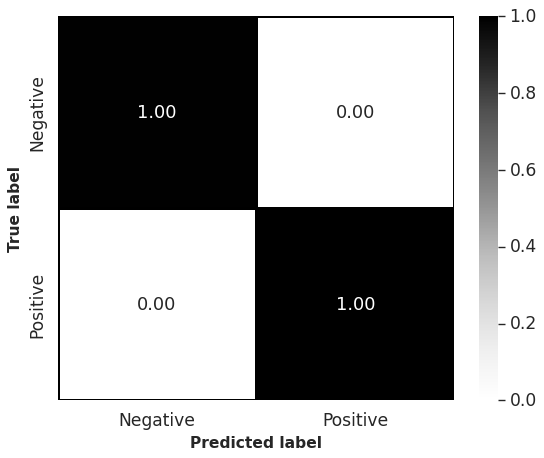

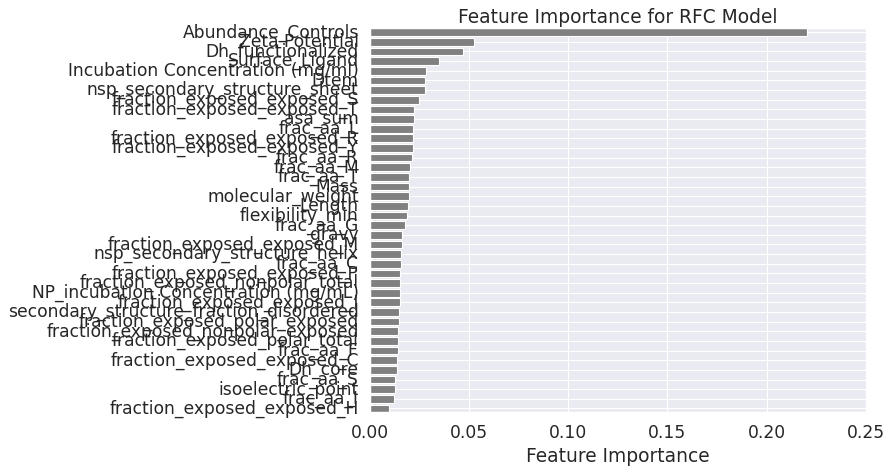

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    # Set the background to white
    plt.gcf().set_facecolor('white')  # Set the figure background to white
    sns.set_style('white')  # Set the seaborn plot style to white
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    #plt.title('Normalized Confusion Matrix:\nBovine Swiss-Prot Intensity', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()


def predict_file(train_file, test_file, name):
    # Initialize RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state = 42)

    # Read the training and test DataFrames
    df_train = pd.read_excel(train_file, header=0)
    df_test = pd.read_excel(test_file, header=0)

    # Preprocess the test data
    # Find the second-smallest value in 'Abundance_Controls' column for testing
    Min_Abund_test = df_test['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    df_test['Abundance_Controls'].replace(0, Min_Abund_test, inplace=True)

    # Calculate 'Enrich' for testing
    df_test['Enrich'] = np.log2(df_test['Abundance'] / df_test['Abundance_Controls'])
    df_test['binary_target'] = df_test['Enrich'].apply(lambda t: 1 if t >= 1 else 0)  # Use the threshold 1 as in training

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    selected_features = df_train.columns.tolist()  # The features used for training
    df_test = df_test[selected_features]  # Filter the test set to include only the selected features

    # Train the RandomForestClassifier on the training data
    model.fit(df_train, y_train)

    # Predict on the test set
    y_pred = model.predict(df_test)
    y_pred_proba = model.predict_proba(df_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Call the function to plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Feature Importance Plot
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.barh(df_train.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for RFC Model')
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}_v3.png')
    plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Metrics_{name}_v3.xlsx', index=False)



# Call Function
predict_file('/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_train_data_Bov SP Intensity_accuracy_v3.xlsx', '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/train_data_Bov SP Intensity.xlsx', 'Bovine_SP_Intensity')



Predicting by Protein

### Predicting by NP

Convert initial df to binary classfication terms

In [ ]:
original_data = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx'

df = pd.read_excel(original_data, header=0).copy()

Min_Abund_test = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df['Abundance_Controls'].replace(0, Min_Abund_test, inplace=True)

# Calculate 'Enrich' for testing
df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= 1 else 0)  # Use the threshold 1 as in training



In [ ]:
npunid_to_full_name = {
    17: "COOH-pNP, 10% FBS",
    18: "COOH-pNP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-pNP, 100% FBS",
    35: "PEG-pNP, 100% FBS (b)"
}

def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.title(f'Normalized Confusion Matrix for NPUNID {name}', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()

# def predict_nanoparticles(train_file, test_file, name):
#     # Initialize RandomForestClassifier
#     model = RandomForestClassifier(n_estimators=100, random_state = 42)

#     # Read the training and test DataFrames
#     #df_train = pd.read_excel(train_file, header=0)
#     #df_test = pd.read_excel(test_file, header=0)

#     # Preprocess the test data
#     # Find the second-smallest value in 'Abundance_Controls' column for testing
#     #Min_Abund_test = df_test['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
#     #df_test['Abundance_Controls'].replace(0, Min_Abund_test, inplace=True)

#     # Calculate 'Enrich' for testing
#     #df_test['Enrich'] = np.log2(df_test['Abundance'] / df_test['Abundance_Controls'])
#     #df_test['binary_target'] = df_test['Enrich'].apply(lambda t: 1 if t >= 1 else 0)  # Use the threshold 1 as in training

#     # Define the target variable for training and testing (binary_target)
#     y_train = train_file['binary_target'].astype(int)
#     y_test = test_file['binary_target'].astype(int)

#     # Drop unnecessary columns in both train and test sets
#     columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
#     train_file.drop(columns=columns_to_drop, inplace=True, errors='ignore')
#     test_file.drop(columns=columns_to_drop, inplace=True, errors='ignore')

#     # Ensure the test data has the same features as the training data
#     #selected_features = features.columns.tolist()  # The features used for training
#     #df_test = df_test[selected_features]  # Filter the test set to include only the selected features

#     # Train the RandomForestClassifier on the training data
#     model.fit(df_train, y_train)

#     # Predict on the test set
#     y_pred = model.predict(df_test)
#     y_pred_proba = model.predict_proba(df_test)

#     # Evaluation metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
#     recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
#     f1 = f1_score(y_test, y_pred, average='macro')
#     auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

#     # Print evaluation metrics
#     print("Accuracy:", accuracy)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("F1 Score:", f1)
#     print("AUROC:", auroc)

#     # Call the function to plot the confusion matrix
#     plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

#     # Feature Importance Plot
#     feature_importances = model.feature_importances_
#     sorted_idx = np.argsort(feature_importances)
#     plt.barh(df_train.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
#     plt.xlabel('Feature Importance')
#     plt.title('Feature Importance for RFC Model')
#     plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}_v3.png')
#     plt.show()

#     # Save evaluation metrics to an Excel file
#     metrics = {
#         "Accuracy": [accuracy],
#         "Precision": [precision],
#         "Recall": [recall],
#         "F1 Score": [f1],
#         "AUROC": [auroc]
#     }

def predict_nanoparticles(df_train, df_test, name):
    # Initialize RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    selected_features = df_train.columns.tolist()  # The features used for training
    df_test = df_test[selected_features]  # Filter the test set to include only the selected features

    # Train the RandomForestClassifier on the training data
    model.fit(df_train[selected_features], y_train)

    # Predict on the test set
    y_pred = model.predict(df_test)
    y_pred_proba = model.predict_proba(df_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Call the function to plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Feature Importance Plot
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.barh(df_train.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {name}')
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}_v3.png')
    plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }







    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Metrics_{name}_v3.xlsx', index=False)



# Manually selected file for 1) original (cleaned) df and 2) RFR RFECV results (to get best_features)
original_data = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_Bov Swiss Intensity.xlsx'
df = pd.read_excel(original_data, header=0).copy()

Min_Abund_test = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
df['Abundance_Controls'].replace(0, Min_Abund_test, inplace=True)

# Calculate 'Enrich' for testing
df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= 1 else 0)  # Use the threshold 1 as in training

feats_from_rfr_rfecv = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_train_data_Bov SP Intensity_accuracy_v3.xlsx'

df_feats = pd.read_excel(feats_from_rfr_rfecv, header=0)

df_modified = df[df_feats.columns.tolist()]
print(df_modified.columns.tolist())
#print(df_modified.head())


# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df_modified['NPUNID'].unique().tolist()
print(np_ids)

for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_modified.loc[df_modified['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_modified.loc[df_modified['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFC model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test results to the full evaluation DataFrame
    full_eval = pd.concat([full_eval, eval], ignore_index=True)

print(full_eval.head())

Output hidden; open in https://colab.research.google.com to view.

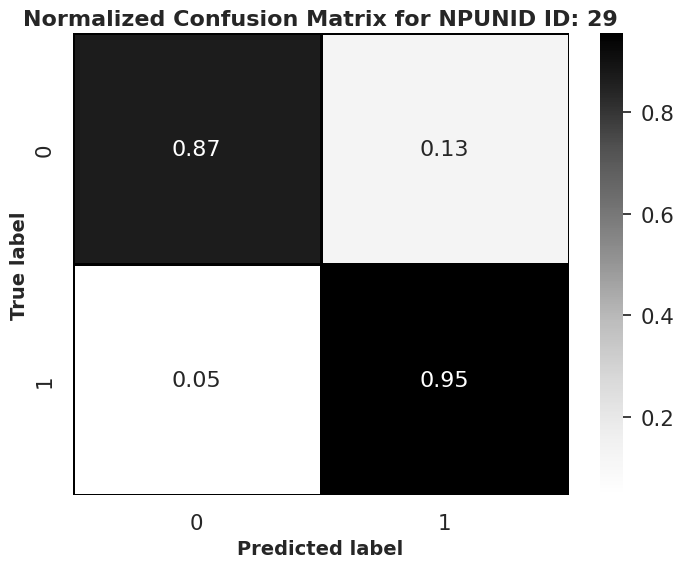

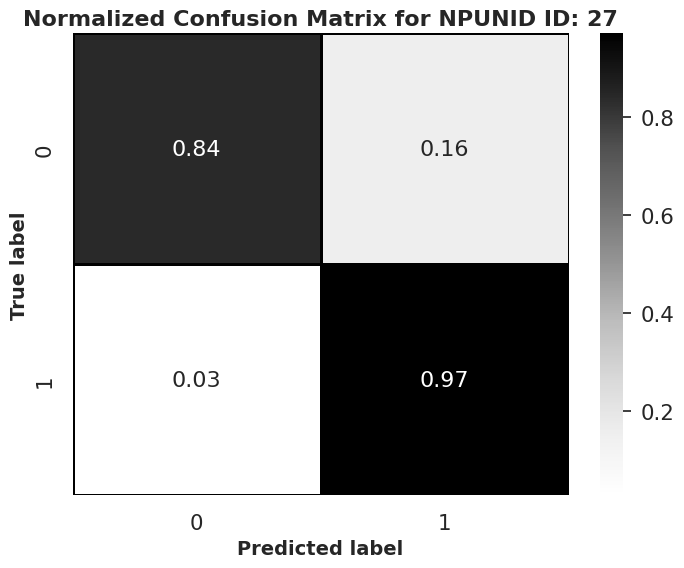

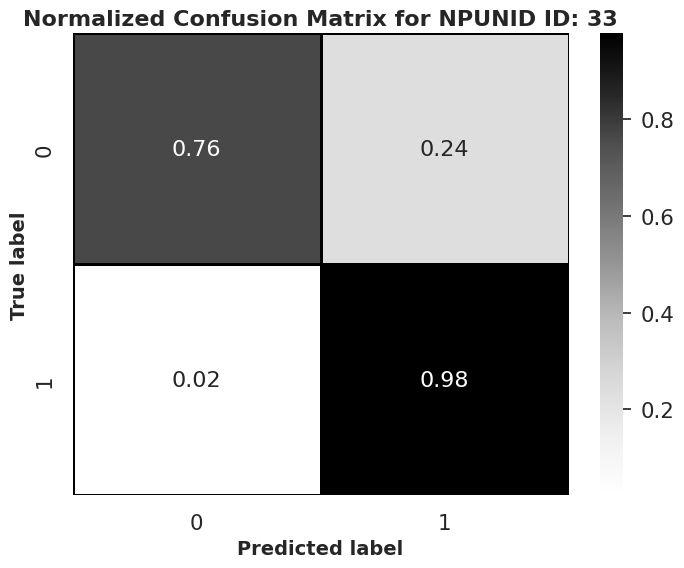

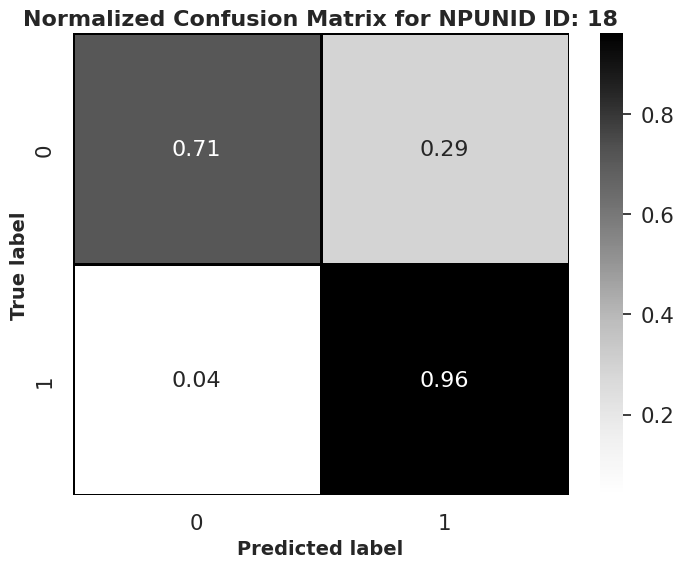

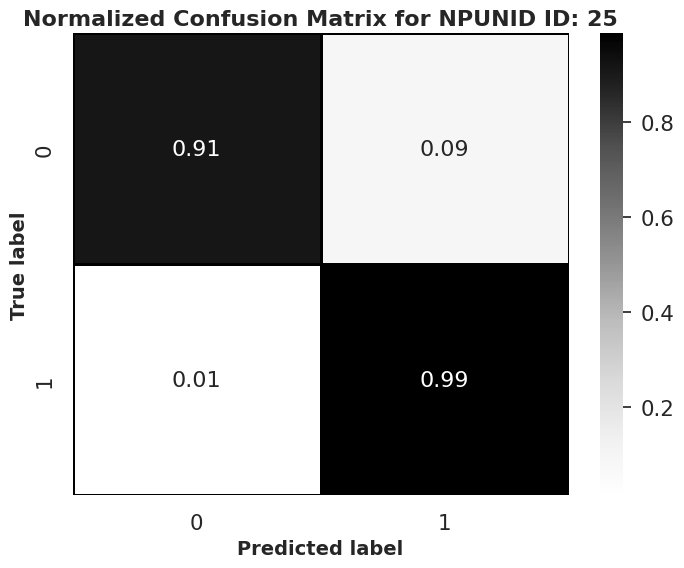

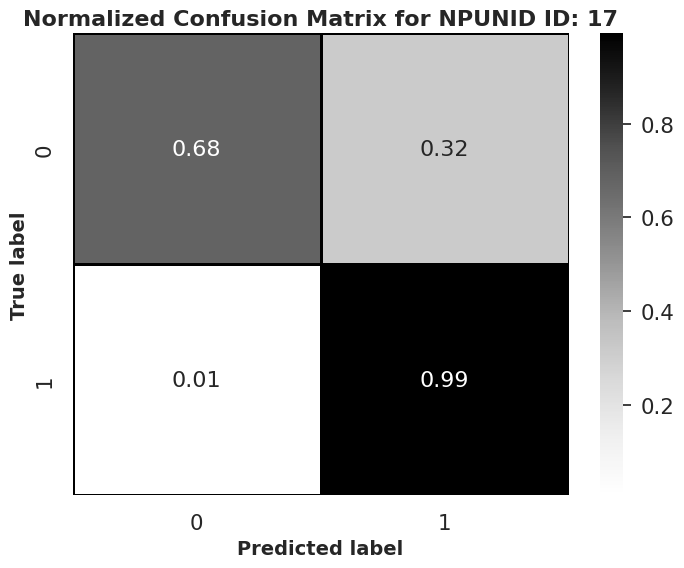

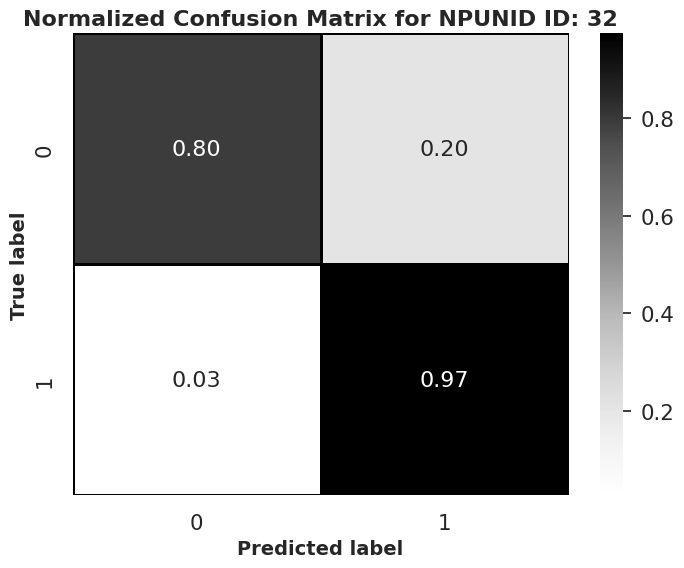

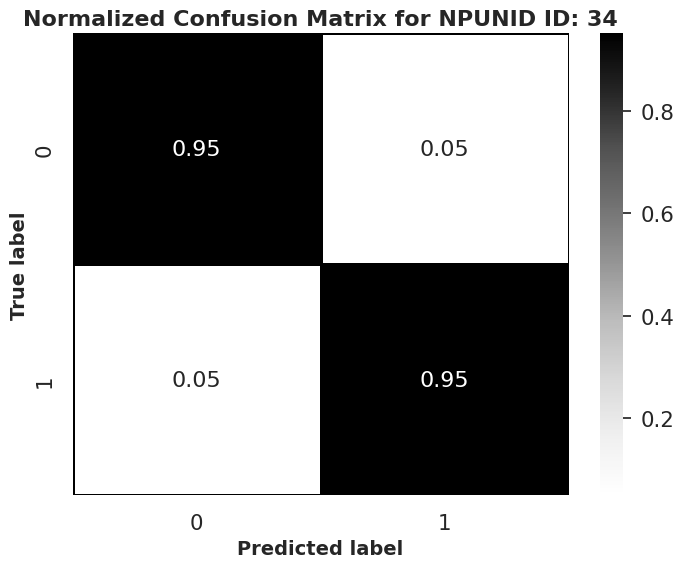

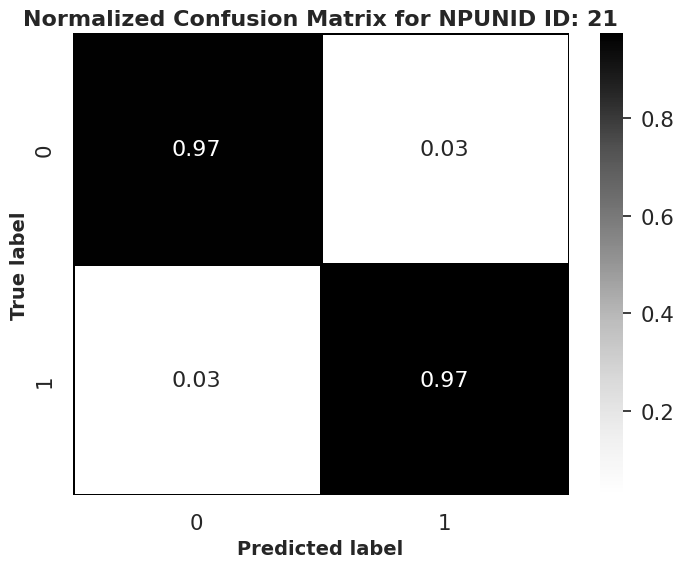

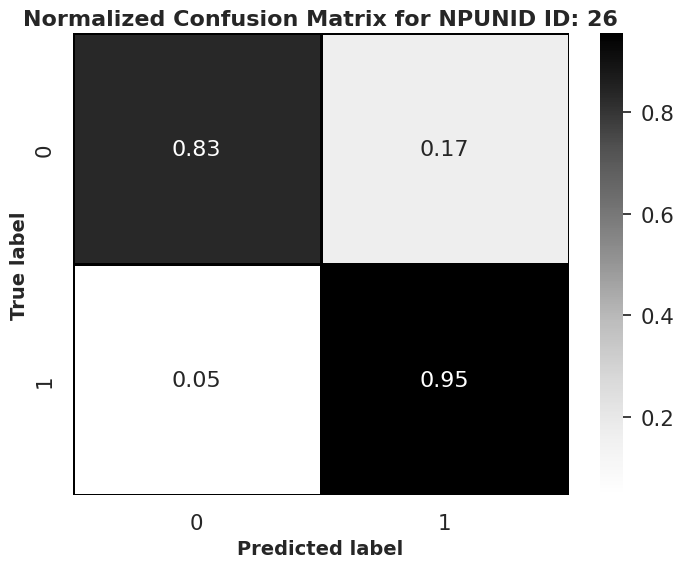

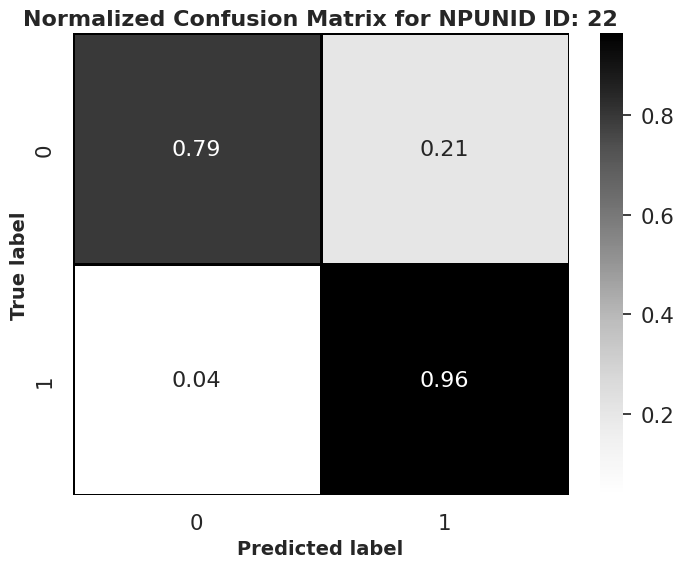

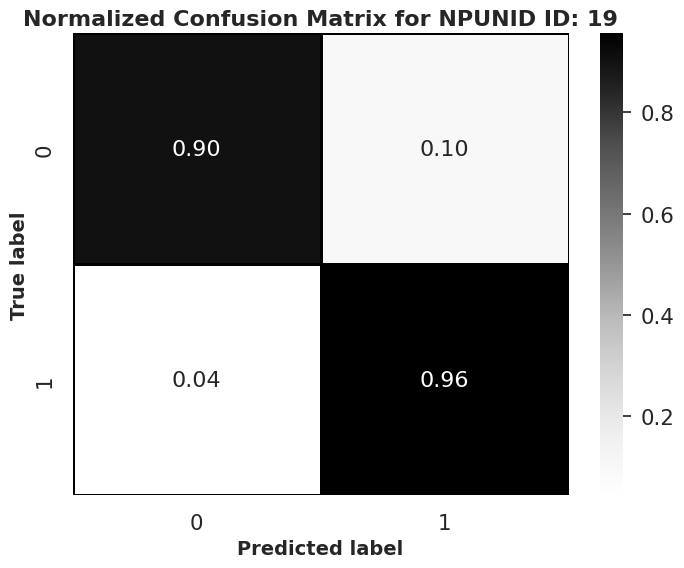

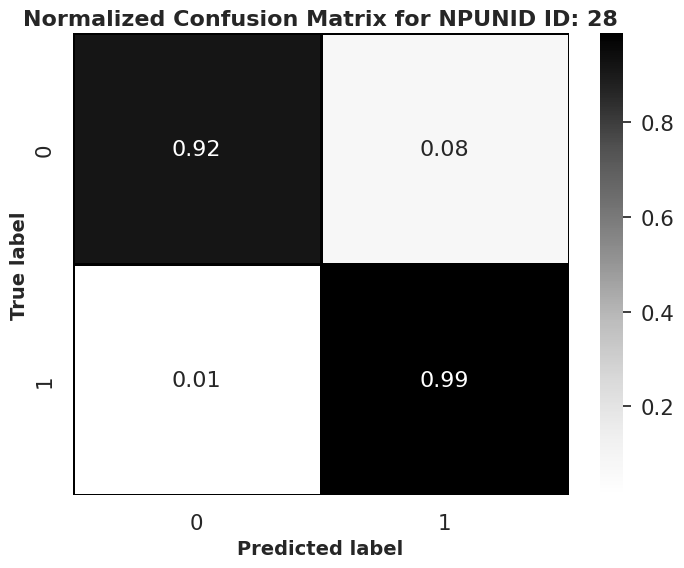

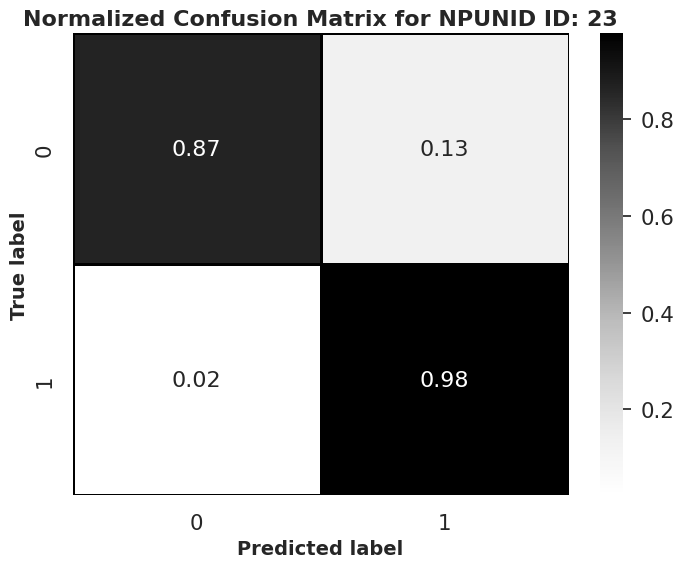

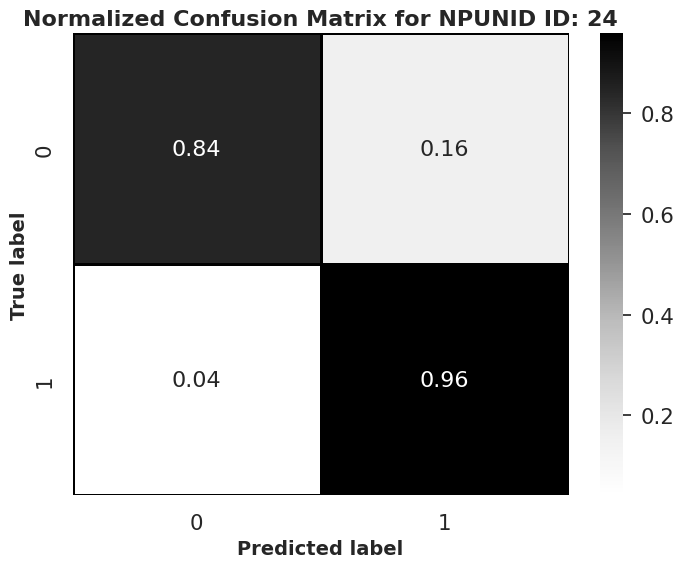

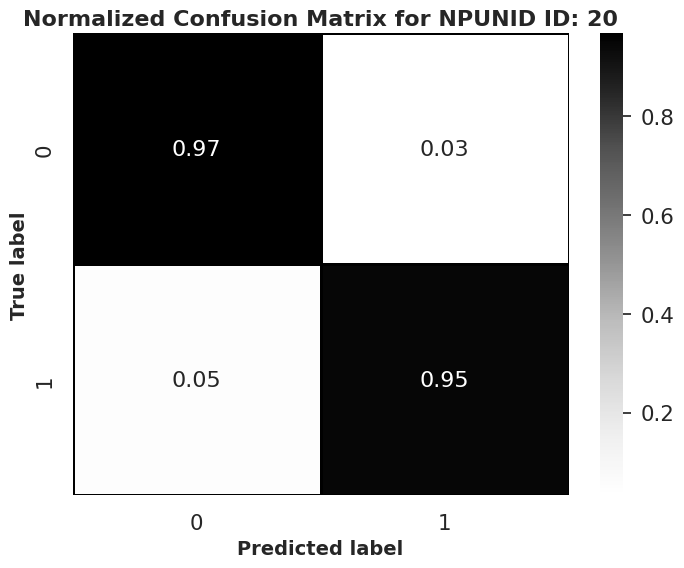

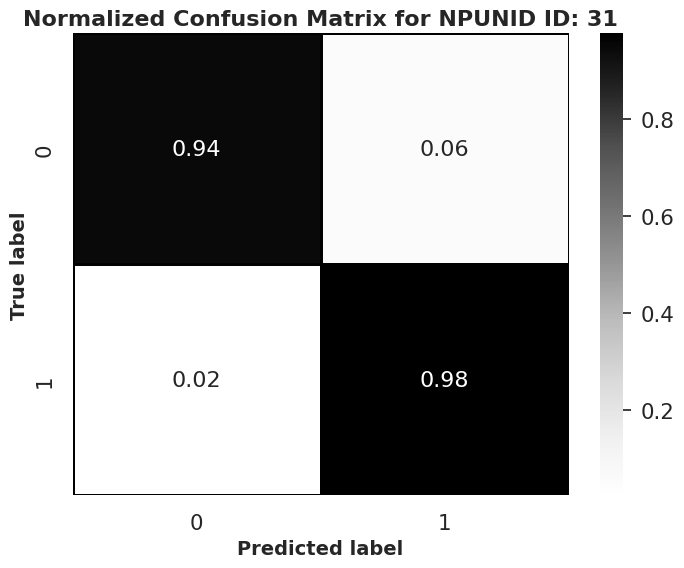

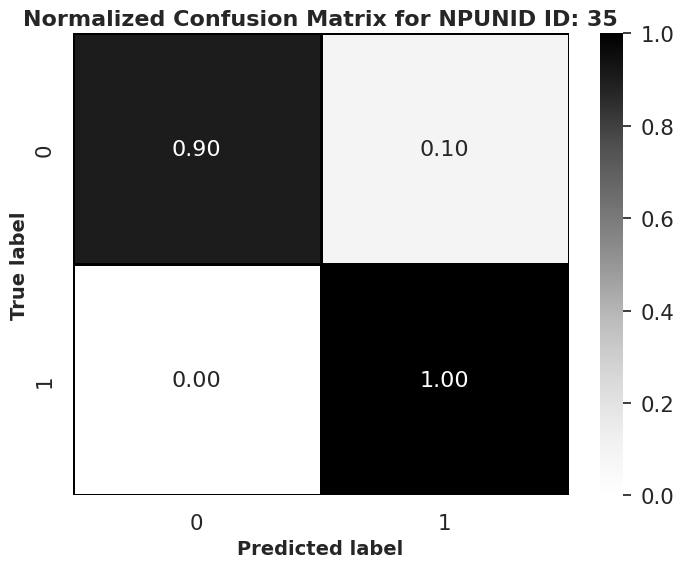

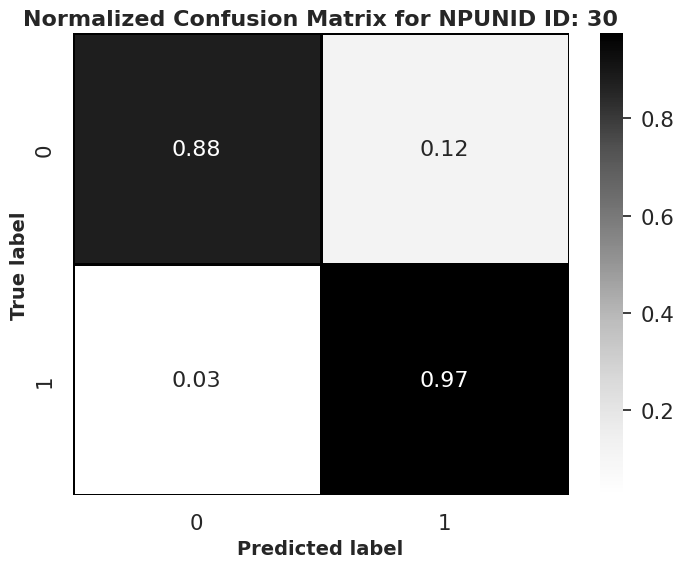

   Accuracy  Precision    Recall  F1-score     AUROC      ID
0  0.932692   0.932692  0.932692  0.932692  0.979915  ID: 29
0  0.933673   0.933256  0.933673  0.932706  0.973342  ID: 27
0  0.927778   0.927126  0.927778  0.925388  0.975845  ID: 33
0  0.904762   0.902070  0.904762  0.901754  0.979757  ID: 18
0  0.969231   0.969036  0.969231  0.968991  0.993945  ID: 25
0  0.919075   0.922945  0.919075  0.913898  0.984294  ID: 17
0  0.908333   0.911505  0.908333  0.906390  0.958732  ID: 32
0  0.950000   0.951204  0.950000  0.950313  0.986388  ID: 34
0  0.972826   0.974528  0.972826  0.973281  0.989263  ID: 21
0  0.928571   0.928571  0.928571  0.928571  0.950294  ID: 26
0  0.930636   0.929403  0.930636  0.929833  0.985506  ID: 22
0  0.947368   0.951298  0.947368  0.948680  0.981771  ID: 19
0  0.975000   0.974814  0.975000  0.974867  0.988974  ID: 28
0  0.947090   0.946818  0.947090  0.946412  0.968978  ID: 23
0  0.931250   0.930710  0.931250  0.930932  0.980479  ID: 24
0  0.951613   0.959282  

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.title(f'Normalized Confusion Matrix for NPUNID {name}', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()



def predict_nanoparticles(train_set, test_set, selected_features, name):
    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100)

    # Prepare the train and test sets with the selected features
    X_train = train_set[selected_features]
    y_train = train_set['binary_target']
    X_test = test_set[selected_features]
    y_test = test_set['binary_target']

    # Train the classifier
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Plot confusion matrix with the previous style
    plot_confusion_matrix(y_test, y_pred, class_names=['0', '1'], name=name)

    # Collect results
    results = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1-score": [f1],
        "AUROC": [auc],
        "ID": name
    })

    return results

def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)

    # Remove columns that should not be considered as potential features in RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies = []
        precisions = []
        recalls = []
        f1s = []
        aurocs = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = df_original['binary_target'].iloc[train_index], df_original['binary_target'].iloc[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Evaluate on validation set
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Drop the feature with the lowest importance sum
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        if combined_score > current_score:
            current_score = combined_score
            selected_features = df.columns.tolist()

    return selected_features, df_original

# Manually selected file path to save to
input_strings = ['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_df_Bov Swiss Intensity.xlsx']

for input_string in input_strings:
    selected_features, df_original = process_file(input_string, 'Bov_Swiss_Intensity')

    # Create new evaluation df that will have the results of everything appended to it
    full_eval = pd.DataFrame()

    # Create a list of all unique NPUNID IDs in current df
    np_ids = df_original['NPUNID'].unique().tolist()

    for np_id in np_ids:
        # Filter df to only include rows with current NPUNID - test set
        current_np = df_original[df_original['NPUNID'] == np_id].copy()
        # Filter df to only include rows without current NPUNID - train set
        temp_df = df_original[df_original['NPUNID'] != np_id].copy()

        # Train RFC model to make predictions on current NPUNID entry
        eval = predict_nanoparticles(temp_df, current_np, selected_features, 'ID: ' + str(np_id))

        # Append the test to the full evaluation df
        full_eval = pd.concat([full_eval, eval])

    print(full_eval)


Label Distribution:
binary_target
1    0.760982
0    0.239018
Name: proportion, dtype: float64


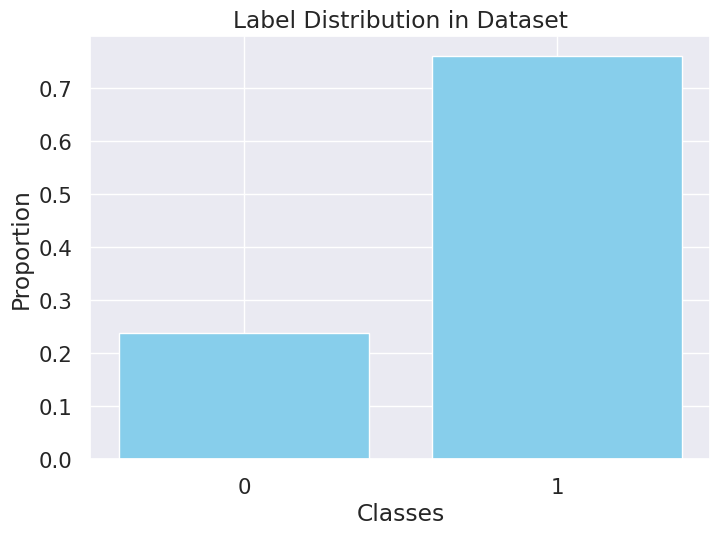

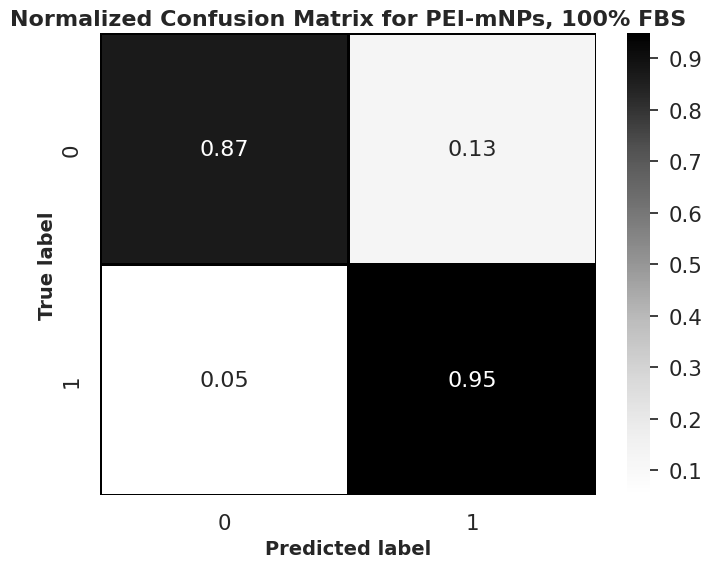

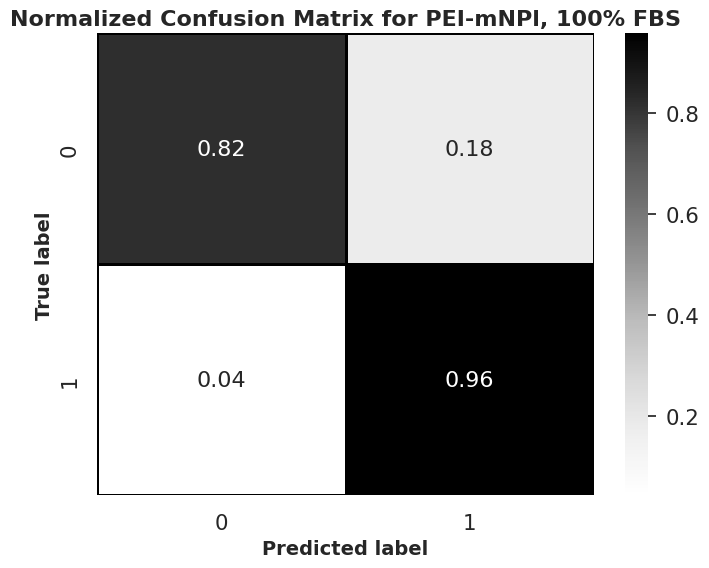

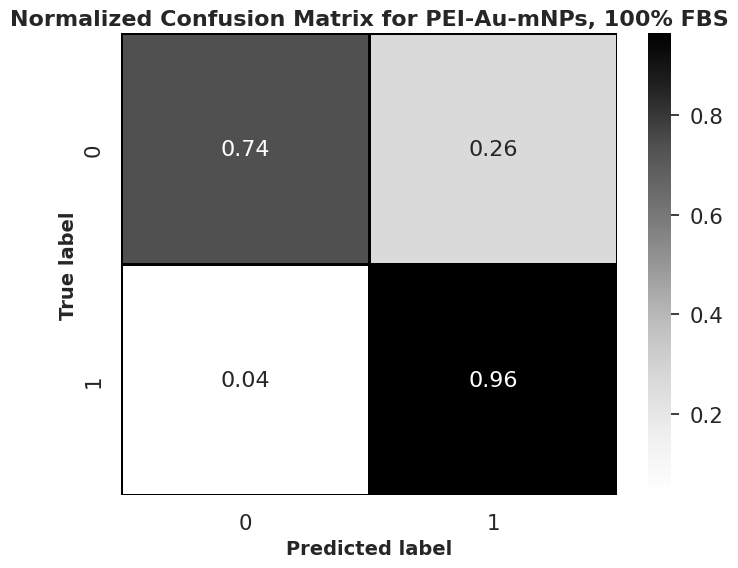

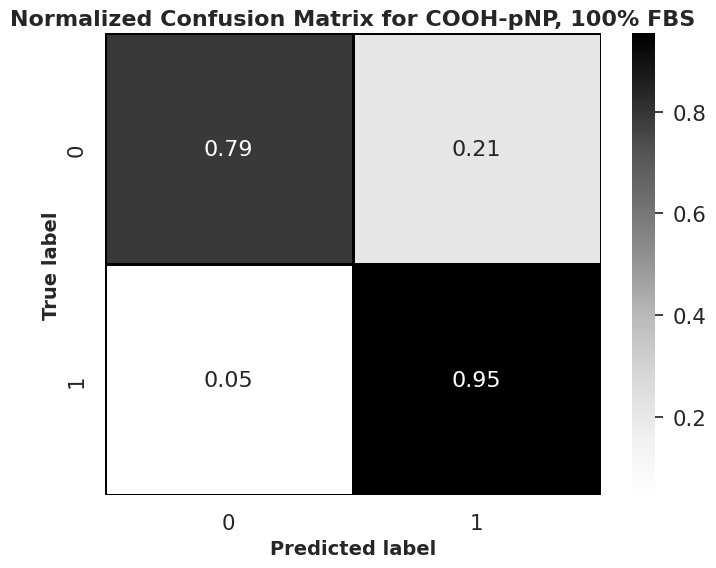

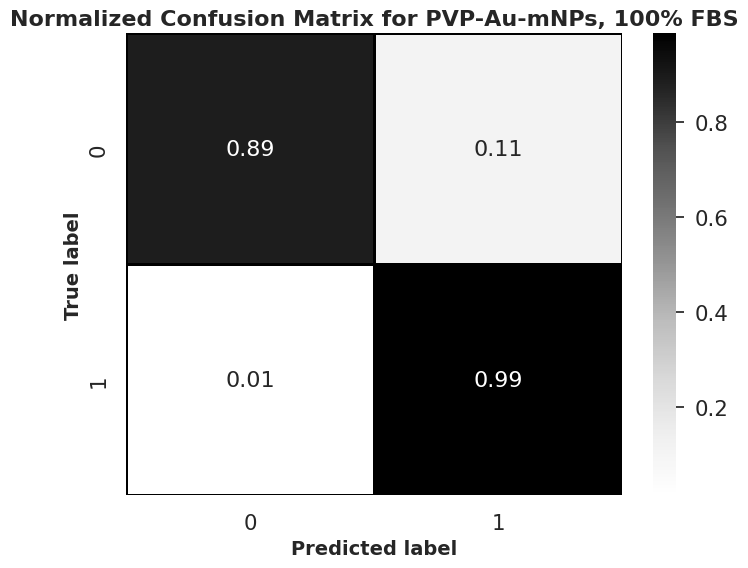

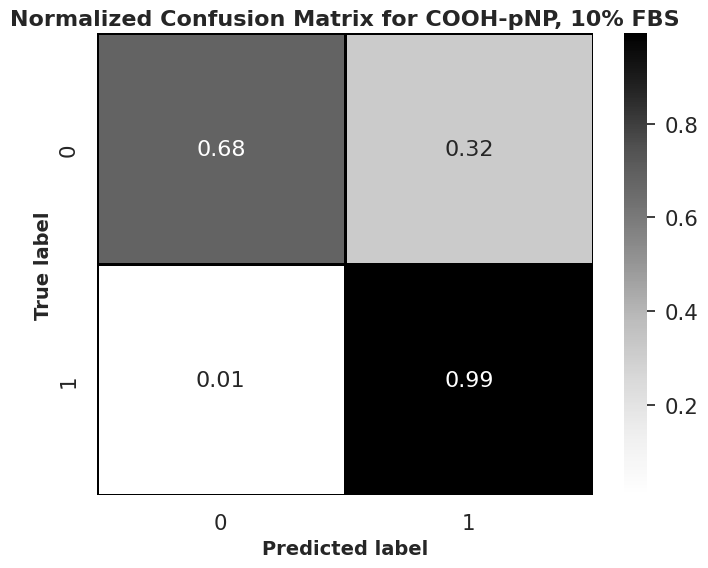

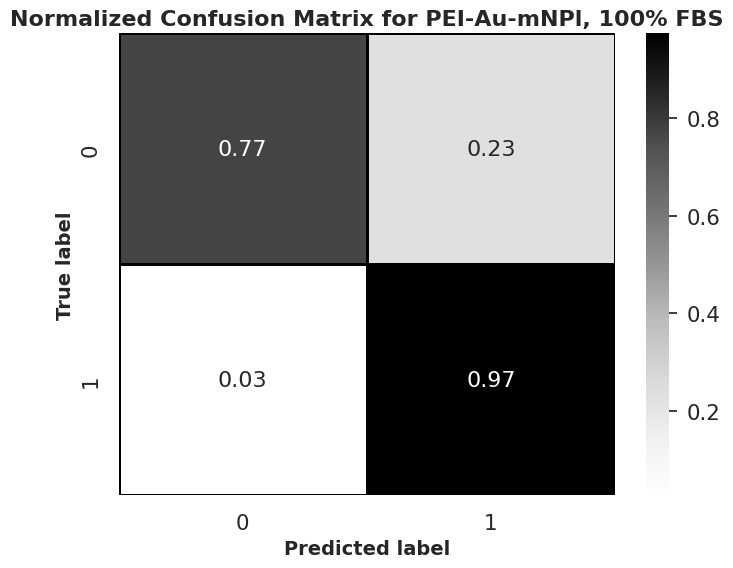

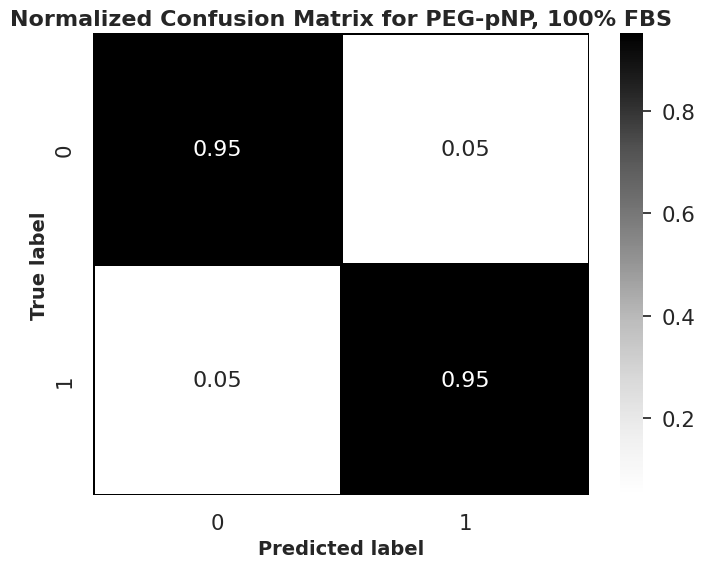

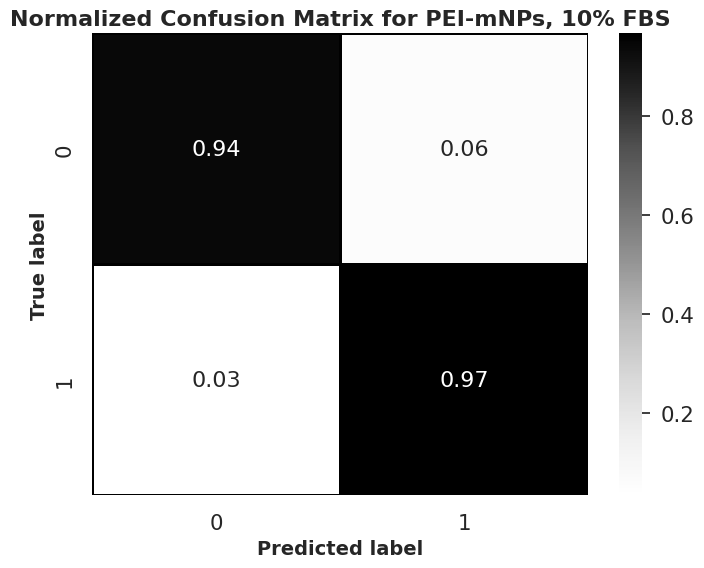

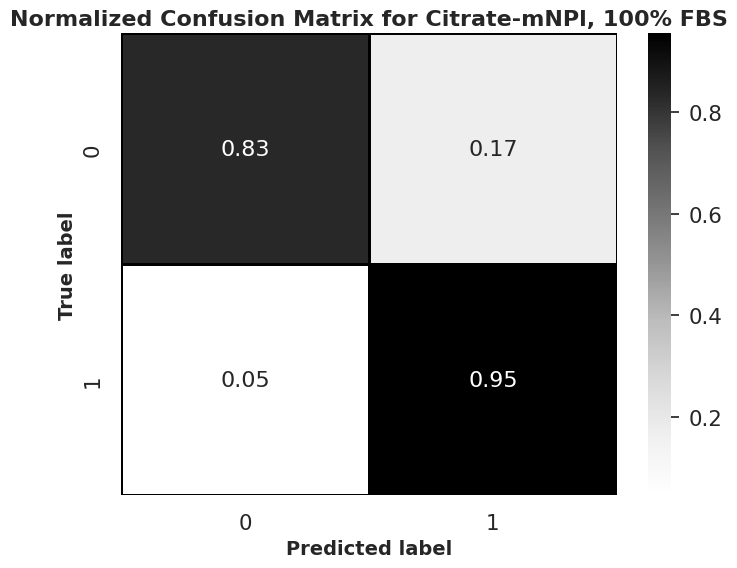

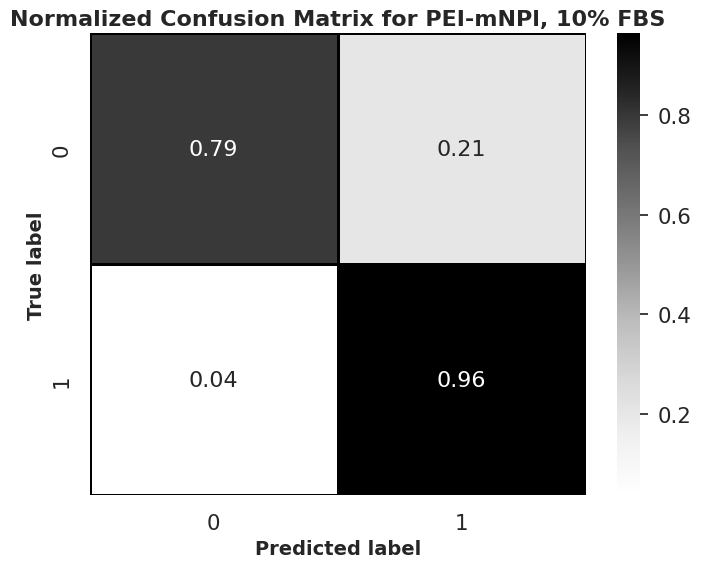

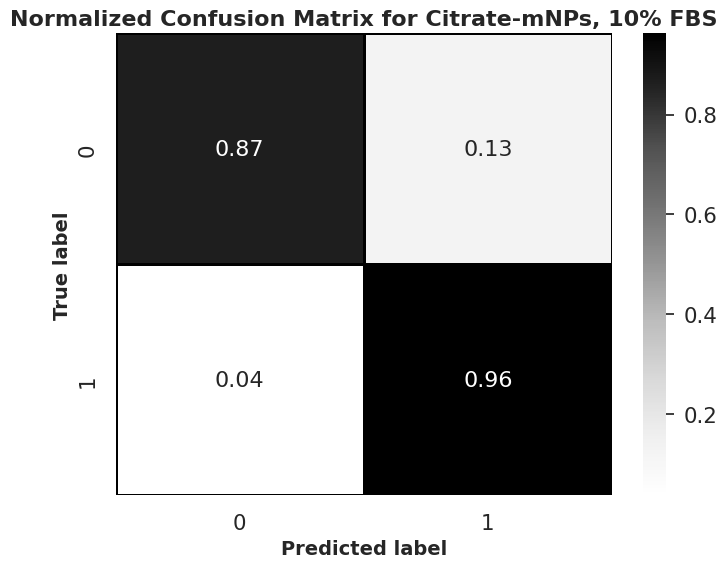

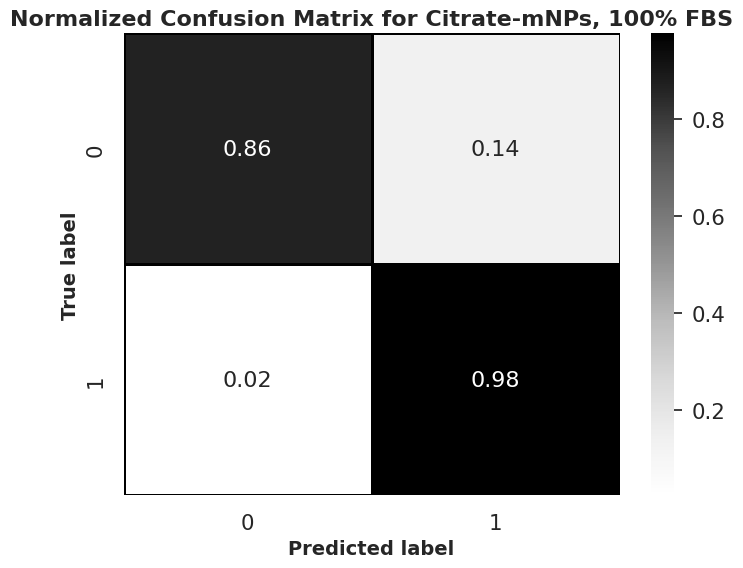

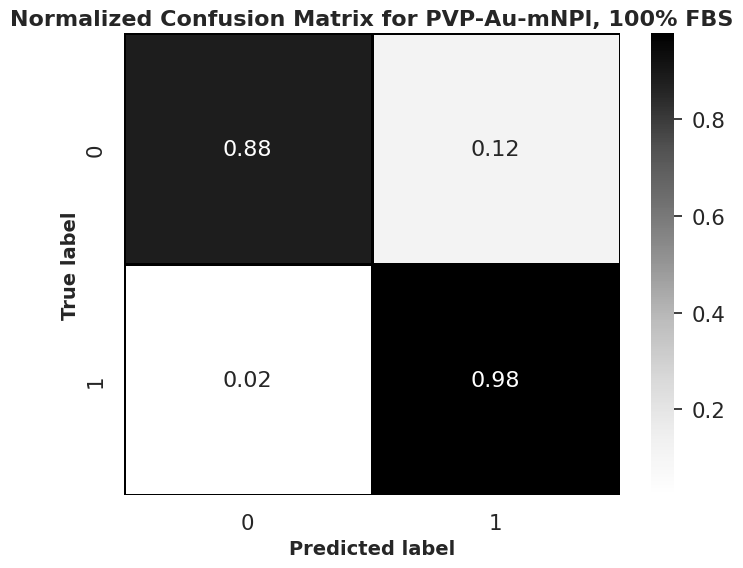

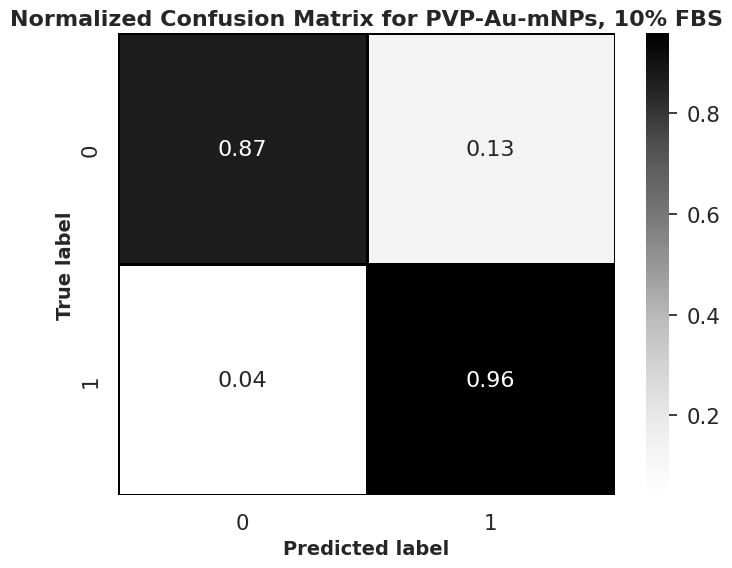

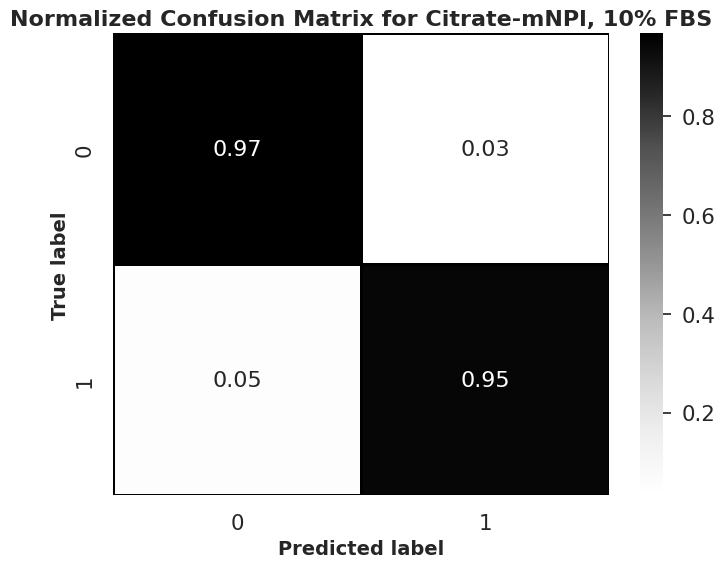

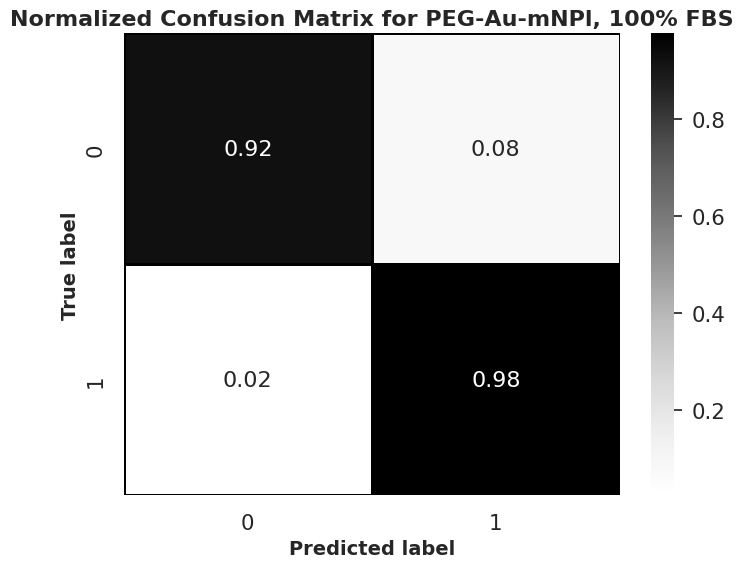

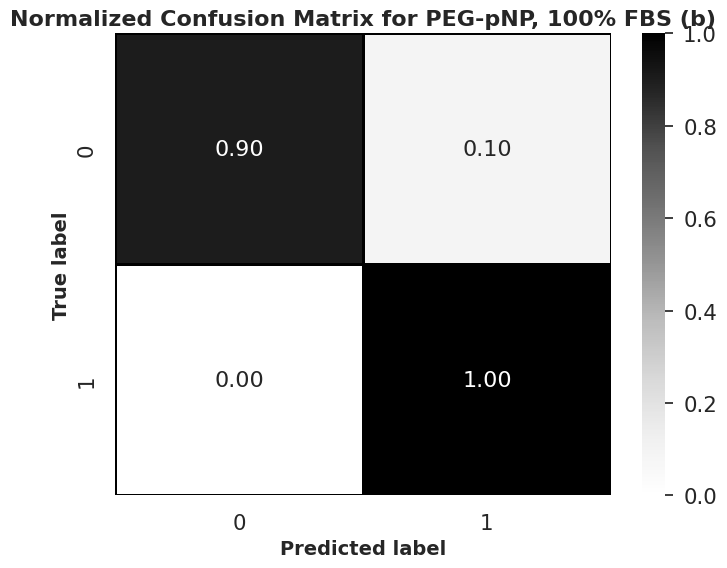

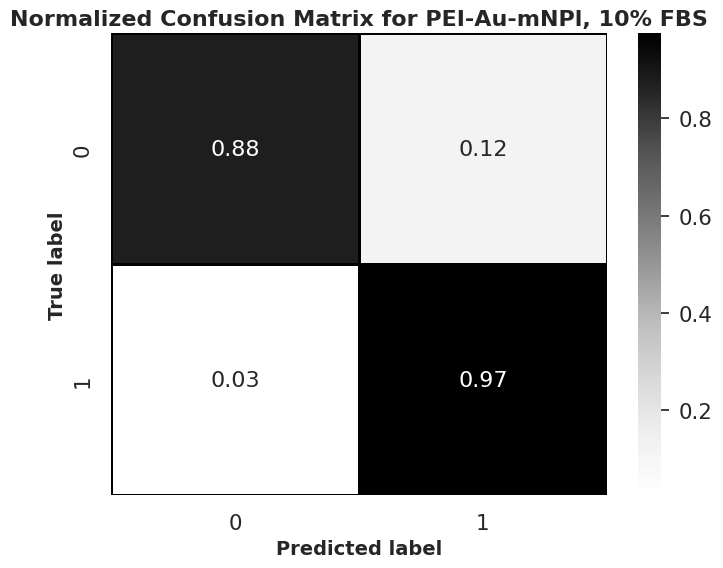

   Accuracy  Precision    Recall  F1-score     AUROC                      ID
0  0.927885   0.928378  0.927885  0.928105  0.967925      PEI-mNPs, 100% FBS
0  0.918367   0.917430  0.918367  0.917431  0.960842      PEI-mNPl, 100% FBS
0  0.911111   0.909028  0.911111  0.908638  0.976794   PEI-Au-mNPs, 100% FBS
0  0.916667   0.915404  0.916667  0.915859  0.980364      COOH-pNP, 100% FBS
0  0.964103   0.963893  0.964103  0.963676  0.995112   PVP-Au-mNPs, 100% FBS
0  0.919075   0.922945  0.919075  0.913898  0.969327       COOH-pNP, 10% FBS
0  0.900000   0.904233  0.900000  0.897500  0.968152   PEI-Au-mNPl, 100% FBS
0  0.950000   0.951204  0.950000  0.950313  0.988762       PEG-pNP, 100% FBS
0  0.961957   0.964001  0.961957  0.962593  0.989464       PEI-mNPs, 10% FBS
0  0.928571   0.928571  0.928571  0.928571  0.951531  Citrate-mNPl, 100% FBS
0  0.930636   0.929403  0.930636  0.929833  0.982861       PEI-mNPl, 10% FBS
0  0.947368   0.949076  0.947368  0.948052  0.968854   Citrate-mNPs, 10% FBS

In [ ]:
# Create a dictionary mapping NPUNID to full sample names
npunid_to_full_name = {
    17: "COOH-pNP, 10% FBS",
    18: "COOH-pNP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-pNP, 100% FBS",
    35: "PEG-pNP, 100% FBS (b)"
}

def check_label_distribution(df, column_name):
    # Calculate the proportion of each class
    label_counts = df[column_name].value_counts(normalize=True)
    print("Label Distribution:")
    print(label_counts)
    plt.bar(label_counts.index, label_counts.values, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Proportion')
    plt.title('Label Distribution in Dataset')
    plt.xticks(label_counts.index)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.title(f'Normalized Confusion Matrix for {name}', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()

def predict_nanoparticles(train_set, test_set, selected_features, name):
    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100)

    # Prepare the train and test sets with the selected features
    X_train = train_set[selected_features]
    y_train = train_set['binary_target']
    X_test = test_set[selected_features]
    y_test = test_set['binary_target']

    # Train the classifier
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Plot confusion matrix with the previous style
    plot_confusion_matrix(y_test, y_pred, class_names=['0', '1'], name=name)

    # Collect results
    results = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1-score": [f1],
        "AUROC": [auc],
        "ID": name
    })

    return results

def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)

    # Check label distribution before removing unnecessary columns
    check_label_distribution(df, 'binary_target')

    # Remove columns that should not be considered as potential features in RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'

    # Define number of folds for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies = []
        precisions = []
        recalls = []
        f1s = []
        aurocs = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = df_original['binary_target'].iloc[train_index], df_original['binary_target'].iloc[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Evaluate on validation set
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Drop the feature with the lowest importance sum
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        if combined_score > current_score:
            current_score = combined_score
            selected_features = df.columns.tolist()

    return selected_features, df_original

# Manually selected file path to save to
input_strings = ['/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFR/Bovine Swiss Intensity/df_RFECV_RFR_df_Bov Swiss Intensity.xlsx']

for input_string in input_strings:
    selected_features, df_original = process_file(input_string, 'Bov_Swiss_Intensity')

    # Create new evaluation df that will have the results of everything appended to it
    full_eval = pd.DataFrame()

    # Create a list of all unique NPUNID IDs in current df
    np_ids = df_original['NPUNID'].unique().tolist()

    for np_id in np_ids:
        # Filter df to only include rows with current NPUNID - test set
        current_np = df_original[df_original['NPUNID'] == np_id].copy()
        # Filter df to only include rows without current NPUNID - train set
        temp_df = df_original[df_original['NPUNID'] != np_id].copy()

        # Get full sample name
        full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

        # Train RFC model to make predictions on current NPUNID entry
        eval = predict_nanoparticles(temp_df, current_np, selected_features, full_name)

        # Append the test to the full evaluation df
        full_eval = pd.concat([full_eval, eval])

    print(full_eval)


Old code
---


df_Bov Swiss Intensity
0    0.956057
1    5.401111
2   -2.749181
3    6.031074
4   -3.042108
Name: Enrich, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: binary_target, dtype: int64
Best Features Names: ['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'molecular_weight', 'flexibility_min', 'gravy', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_Ligand', 'Dtem', 'Dh_functionalized', 'NP_incubation Concentration (mg/mL)', 'Incubation Concentration (mg/ml)']
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R'

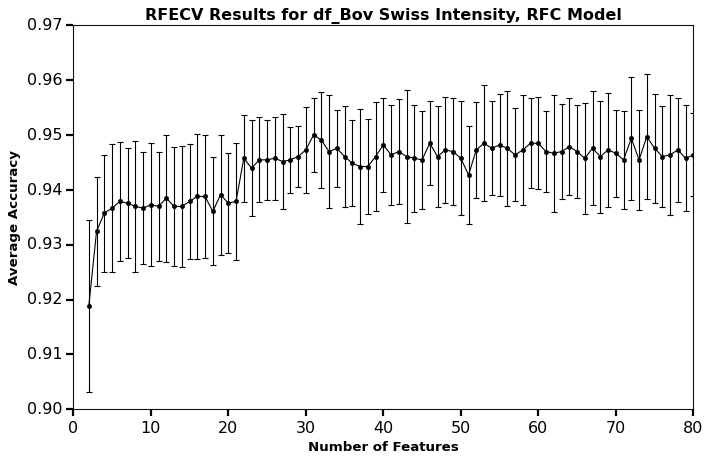

All files processed!


In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    #df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    #y_label = df['binary_target'].copy().values
    label_df = df['binary_target'].copy()

    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg accuracy": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        avg_accuracies = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Evaluate on validation set
            accuracy = model.score(X_test, y_test)
            avg_accuracies.append(accuracy)

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average accuracy across all folds
        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        # If this is the best combo, save it
        combined_score = avg_accuracy - std_dev - (n_features / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features, avg_accuracy, std_dev, ", ".join(df.columns), combined_score]

        # Drop the feature with the lowest importance sum
        # min_feature = min(feat_dict, key=feat_dict.get)
        # df_features = df_features.drop(columns=[min_feature])
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_RFC_results_{name}_{identifier}.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feats_RFECV_RFC_{name}_{identifier}.xlsx', index=False)
    RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Top3/Scores_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    ax.errorbar(df_full_results["Number of features"], df_full_results["Avg accuracy"],
            yerr=df_full_results["Std dev"], fmt='-o', color="black",
            elinewidth=1, capsize=3, capthick=1, markersize=4)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Average Accuracy', fontweight='bold', color='black')
    ax.set_title(f'RFECV Results for {name}, RFC Model', fontweight='bold', color='black')

    # Adjust tick parameters using 'ax'
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2,
               colors='black', labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=None, right=80)
    ax.grid(False)  # Control grid directly on 'ax'

    # Save the plot
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_plot_{name}.png')
    plt.show()
    plt.close()


# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")

RFE

In [ ]:
selected_features_dict = {}

for file in processed_files:
    print(file)
    df = pd.read_excel(file, header=0)
    df_original = df.copy()

    model = RandomForestClassifier(n_estimators=100)

    # RFE/RFECV Variables
    step = 1
    min_feats = 1
    identifier = 'neg_mean_squared_error' # do I need this?
    fold_num = 10
    keep_columns = ['Abundance', 'NPUNID', 'Entry']

    # 'Abundance' column in df represents a 1D array of target values (class labels)
    #y_label = np.log2(df['Abundance'].values.astype(float))
    y_label = df['Abundance'].astype(str)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.1, random_state=42)

    # Perform feature selection using RFE
    rfe = RFE(model, n_features_to_select=16, step=step)
    rfe = rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_].tolist()
    selected_features_dict[file] = selected_features  # Store selected features for this file in the dictionary
    feature_importances = rfe.estimator_.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Train model with selected features
    model.fit(X_train[selected_features], y_train)

    # Predict on testing set
    y_pred = model.predict(X_test[selected_features])

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_rep)

    # Store selected features and evaluation metrics in dictionary
    selected_features_dict[file] = {'selected_features': selected_features,
                                    'accuracy': accuracy,
                                    'classification_report': classification_rep}

    print("Selected Features Dictionary:")
    pprint.pprint(selected_features_dict)

/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_NormBov Swiss Intensity_modified.xlsx
                                    Feature  Importance
0   secondary_structure_fraction_disordered    4.657288
1                                  rsa_mean    4.485184
2                fraction_exposed_exposed_A    4.792967
3                fraction_exposed_exposed_E    4.676688
4                fraction_exposed_exposed_G    4.757189
5                fraction_exposed_exposed_M    4.686532
6                fraction_exposed_exposed_N    4.653055
7                fraction_exposed_exposed_Q    4.804362
8                fraction_exposed_exposed_T    4.668208
9                fraction_exposed_exposed_V    4.636787
10                           Zeta Potential    9.897093
11                           Surface_Ligand    7.021429
12                                     Dtem    7.882729
13                                  Dh_core    4.912587
14                      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy: 0.0
Classification Report:
               precision    recall  f1-score   support

  0.00036642       0.00      0.00      0.00       1.0
 0.000420663       0.00      0.00      0.00       0.0
 0.000545879       0.00      0.00      0.00       1.0
 0.000564092       0.00      0.00      0.00       1.0
 0.000606788       0.00      0.00      0.00       1.0
 0.000609975       0.00      0.00      0.00       1.0
 0.000612915       0.00      0.00      0.00       0.0
 0.000653526       0.00      0.00      0.00       1.0
 0.000667544       0.00      0.00      0.00       1.0
 0.000761403       0.00      0.00      0.00       1.0
  0.00078792       0.00      0.00      0.00       1.0
 0.000798327       0.00      0.00      0.00       0.0
 0.000801214       0.00      0.00      0.00       0.0
 0.000812336       0.00      0.00      0.00       0.0
 0.000833537       0.00      0.00      0.00       0.0
 0.000853558       0.00      0.00      0.00       1.0
 0.000854544       0.00      0.00      0.00

KeyboardInterrupt: 

Visulization of Predicted Abundance Value for Important Features

In [ ]:
for file in processed_files:
    print(file)
    for i, feature in enumerate(selected_features):
        feature_index = df.columns.get_loc(feature)
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

        file_name = file

        # Split the file path using the '/' delimiter
        file_parts = file_name.split('/')

        # Extract the last part of the file path, which contains the file name
        file_name_part = file_parts[-1]

        # Split the file name using '_' as the delimiter
        file_name_parts = file_name_part.split('_')

        # Extract the relevant part of the file name
        desired_name = ' '.join(file_name_parts[1:-1])


        # Plot y_pred vs y_test
        ax = axes[0]
        ax.scatter(y_test, y_pred, color='salmon')
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray')  # Identity line
        ax.set_xlabel('True Abundance (log)')
        ax.set_ylabel('Predicted Abundance (log)')
        ax.set_title(f'{desired_name}: {feature}')

        #Plot X_test vs y_test
        ax = axes[1]
        ax.scatter(X_test.iloc[:, feature_index], y_test, color='dodgerblue', label='Feature Values')
        ax.set_xlabel(f'{feature} Values')
        ax.set_ylabel('True Protein Abundance')
        ax.set_title(f'{desired_name}: {feature}')
        ax.legend()

        plt.tight_layout()
        plt.show()

Selected Feature Analysis


In [ ]:
for file in processed_files:
    df = pd.read_excel(file, header=0)
    df_original = df.copy()

    # Perform RFECV after RFE
    rfecv = RFECV(estimator=model, cv=5)
    rfecv.fit(X_train[selected_features], y_train)

    # Plot number of features vs. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score")
    plt.title("RFECV Results")
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.show()

    # Print the optimal number of features
    print("Optimal number of features: %d" % rfecv.n_features_)

    # Assess feature importance
    selected_features_rfecv = [selected_features[i] for i in range(len(selected_features)) if rfecv.support_[i]]
    print("Selected features after RFECV:", selected_features_rfecv)

Individual Protein Analysis

Grouped by Unique Protein ID from Uniprot

In [ ]:
# might need to have a bit of 'hard coding'; specifically, need to enter in the file you are searching through.

# why are there more data points on the later figures in this cell's output?

# assign file path directory to 'file' variable; do for each file wanting processing
file = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/df_NormBov Swiss Intensity_modified.xlsx'

df = pd.read_excel(file, header=0)
grouped_dfs = []

selected_features = selected_features_dict[file]['selected_features']  # Access selected features for this file
for entry, group_df in df.groupby('Entry'):
  mean_abundance = group_df['Abundance'].mean()
  group_df['Mean_Abundance'] = mean_abundance.round(2)
  grouped_dfs.append(group_df)

  # Calculate abundance deviation for each entry in the group
  group_df['Abundance_Deviation'] = (group_df['Abundance'] - mean_abundance).round(2)
  group_df['Abundance'] = group_df['Abundance'].round(2)

for group_df in grouped_dfs:
    group_df['Mean_Abundance'] = pd.to_numeric(group_df['Mean_Abundance'], errors='coerce')

sorted_grouped_dfs = sorted(grouped_dfs, key=lambda x: x['Mean_Abundance'].max(), reverse=True)

top_grouped_dfs = sorted_grouped_dfs[:10]

for group_df in top_grouped_dfs:
    print(group_df[['NPUNID','Entry','Abundance','Mean_Abundance', 'Abundance_Deviation']])

In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    y_label = df['binary_target'].copy().values

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                       'Ligands', 'BatchID', 'Protein Source', 'binary_target']
    df_features = df.drop(columns=columns_to_drop, errors='ignore')

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the range of features to select
    max_features = df_features.shape[1]
    min_features = 1

    current_score = float(-1)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg accuracy": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        avg_accuracies = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df_features.columns}

        for train_index, test_index in kf.split(df_features):
            X_train, X_test = df_features.iloc[train_index], df_features.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Evaluate on validation set
            accuracy = model.score(X_test, y_test)
            avg_accuracies.append(accuracy)

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df_features.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average accuracy across all folds
        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        # If this is the best combo, save it
        combined_score = avg_accuracy - std_dev - (n_features / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features, avg_accuracy, std_dev, ", ".join(df_features.columns), combined_score]

        # Drop the feature with the lowest importance sum
        min_feature = min(feat_dict, key=feat_dict.get)
        df_features = df_features.drop(columns=[min_feature])

        if combined_score > current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df_features.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/RFECV_RFC_results_{name}_{identifier}.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Feats_RFECV_RFC_{name}_{identifier}.xlsx', index=False)
    RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Scores_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/df_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")


df_Bov Swiss Intensity
0    0.956057
1    5.401111
2   -2.749181
3    6.031074
4   -3.042108
Name: Enrich, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: binary_target, dtype: int64


Exception in thread Thread-13 (process_file):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-9-2e9ab606bfd8>", line 100, in process_file
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3767, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 5877, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 5941, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['Enrich', 'binary_target'] not in index"


Best Features Names: ['Enrich']
['Enrich', 'Abundance', 'NPUNID', 'Entry', 'binary_target']
All files processed!


In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # X variable is from df, y variable is 'Abundance' column in df

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy() # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    y_value = df['binary_target'].copy()

    # 'Abundance' column in df represents a 1D array of target values (class labels)
    #y_label = np.log2(df['Abundance'].to_numpy().astype(float)) # changed to_numpy() from values
    #y_label = np.log2(y_label.to_numpy().astype(float))

    y_label = np.ravel(y_value)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in df.columns]

    # Drop columns safely
    if all(col in df.columns for col in columns_to_drop):
      df.drop(columns=columns_to_drop, inplace=True)
    else:
      missing_cols = [col for col in columns_to_drop if col not in df.columns]
      print("Warning: Attempting to drop non-existent columns:", missing_cols)

    print(df.columns)


    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_featires = None
    current_score = float(-1)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg accuracy": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})


    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
      avg_accuracies = []

      # Make a dictionary with feature name keys
      feat_dict = {key: 0 for key in df.columns}

      for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y_label[train_index], y_label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Evaluate on validation set
        accuracy = model.score(X_test, y_test)
        avg_accuracies.append(accuracy)

        # During each iteration, each feature will get an importance
        for idx, feature in enumerate(df.columns):
          feat_dict[feature] += model.feature_importances_[idx]

      # Calculate average accuracy across all folds
      avg_accuracy = np.mean(avg_accuracies)
      std_dev = np.std(avg_accuracies)

      # If this is the best combo, save it
      combined_score = avg_accuracy - std_dev - (n_features / 5000)
      df_full_results.loc[len(df_full_results)] = [n_features, avg_accuracy, std_dev, ", ".join(df.columns),combined_score]

      # Drop the feature with the lowest importance sum
      df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

      if combined_score > current_score:
        current_score = combined_score
        # Selecting the best features of the current df
        best_features = df.columns.tolist()


    print("Best Featurs Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/RFECV_RFC_results_{name}_{identifier}.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determin feature importance and metrics fro each DataFrame
    df = df_original[best_features].copy()
    df.head()

    RFC_Scores, feats = scorer_RFC(df, y_label, model, identifier, 10)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Feats_RFECV_RFC_{name}_{identifier}.xlsx', index=False)
    RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Scores_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/df_RFECV_RFC_{name}_{identifier}.xlsx', index=False)


# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")



df_Bov Swiss Intensity
0    0.956057
1    5.401111
2   -2.749181
3    6.031074
4   -3.042108
Name: Enrich, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: binary_target, dtype: int64
Index(['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C',
       'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H',
       'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N',
       'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T',
       'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight',
       'aromaticity', 'instability_index', 'flexibility_mean',
       'flexibility_std', 'flexibility_max', 'flexibility_min',
       'isoelectric_point', 'secondary_structure_fraction_helix',
       'secondary_structure_fraction_turn',
       'secondary_structure_fraction_sheet',
       'secondary_structure_fraction_disordered', 'gravy', 'Unnamed: 0',
       'fraction_exposed', 'fraction_buried',
       'fraction_exposed_nonpolar_total', 'fraction_e

Exception in thread Thread-13 (process_file):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-9-98ecd551510d>", line 119, in process_file
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3767, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 5877, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 5938, in _raise_if_missing
    raise KeyError(f"None of [{key}] are in the [{axis_name}]")
KeyError: "None of [Index(['binary_target'], dtype='object')] are in the [columns]"


['binary_target', 'Abundance', 'NPUNID', 'Entry', 'binary_target']
All files processed!


In [ ]:
# IGNORE - delete later

# verifying the helper functions Python script is properly loaded: should print out 'test!'
from importlib import reload
import data_prep_functions
reload(data_prep_functions)
from data_prep_functions import *


test!


In [ ]:
# For shorter computing time, run one file at a time
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Input_DataFrames/post_clean_up_dfs/'


file_beginning = 'df_'
file_group = 'Bov Swiss' # options are 'Bov Swiss', 'Bov Swiss Tremble (Still working on this name)
file_ending = 'Intensity.xlsx' # options are 'Intensity.xlsx', 'Top3.xlsx', 'iBAQ.xlsx'
files = []

for file in os.listdir(input_directory):
    if file_group in file and file_ending in file:
        files.append(file)

print(files)

['df_Bov Swiss Intensity.xlsx', 'df_Bov Swiss + TrEMBLE Intensity.xlsx']


In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    #df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    #y_label = df['binary_target'].copy().values
    label_df = df['binary_target'].copy()

    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg accuracy": [],
                                    "Std dev": [],
                                    "Avg precision": [],
                                    "Precision std": [],
                                    "Avg recall": [],
                                    "Recall std": [],
                                    "Avg f1": [],
                                    "F1 std": [],
                                    "Avg AUROC": [],
                                    "AUROC std": [],
                                    "List of features": [],
                                    "Combined Score": []})

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies, precisions, recalls, f1s, aurocs = [], [], [], [], []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the Classifier
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Ensure binary classification for single column proba

            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Record the results
        df_full_results.loc[len(df_full_results)] = {
            'Number of features': n_features,
            'Avg accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
            'Avg precision': avg_precision, 'Precision std': std_precision,
            'Avg recall': avg_recall, 'Recall std': std_recall,
            'Avg f1': avg_f1, 'F1 std': std_f1,
            'Avg AUROC': avg_auroc, 'AUROC std': std_auroc,
            'List of features': ", ".join(df.columns),
            'Combined Score': avg_accuracy - std_accuracy - (n_features / 5000)  # Custom scoring formula
        }

        # If this is the best combo, save it
        combined_score = avg_accuracy - std_dev - (n_features / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features, avg_accuracy, std_dev, ", ".join(df.columns), combined_score]

        # Update the DataFrame by dropping the least important feature
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_RFC_results_{name}_{identifier}.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feats_RFECV_RFC_{name}_{identifier}.xlsx', index=False)
    RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Top3/Scores_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_{name}_{identifier}.xlsx', index=False)

    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    metrics = ['Avg accuracy', 'Avg precision', 'Avg recall', 'Avg f1', 'Avg AUROC']
    for metric in metrics:
        ax.plot(df_full_results['Number of features'], df_full_results[metric], label=metric)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Metric Scores', fontweight='bold', color='black')
    ax.set_title(f'RFECV Results for {name}, RFC Model', fontweight='bold', color='black')
    ax.legend()
    ax.grid(True)
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_plot_{name}.png')
    plt.show()
    plt.close()


# Initialize an empty list to store threads
threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        # Create a thread that runs process_file on each Excel file
        thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")

df_Bov Swiss Intensity
0    0.956057
1    5.401111
2   -2.749181
3    6.031074
4   -3.042108
Name: Enrich, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: binary_target, dtype: int64


Exception in thread Thread-18 (process_file):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-27-e7d93dfc8c49>", line 107, in process_file
NameError: name 'std_dev' is not defined


All files processed!


In [ ]:
# holding cell for code

# Plotting with specified layout and style
    # plt.style.use('classic')
    # fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    # plt.rcParams['figure.dpi'] = 300
    # ax.scatter(y_test, y_pred, color='black', s=10)
    # ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
    # ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    # ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    # ax.set_title(f"NPUNID {name}", fontweight='bold', color='black')
    # ax.set_xlim(left=-2, right=6)
    # ax.set_ylim(bottom=-2, top=6)

    # # Add metrics box to the plot
    # box_text = f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}\nAUROC: {auroc:.2f}"
    # props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    # ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # ax.tick_params(axis='both', which='both', direction='out', length=6, width=2, colors='black',
    #                labelsize='large', labelcolor='black', bottom=True, top=False, left=True, right=False)
    # ax.grid(False)
    # plt.tight_layout()

    # # Save and show the plot
    # plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/TEST_{name}.png')
    # plt.show()
    # plt.close()

df_RFECV_RFC_df_Bov Swiss Intensity_accuracy.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'molecular_weight', 'flexibility_min', 'gravy', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_Ligand', 'Dtem', 'Dh_functionalized', 'NP_incubation Concentration (mg/mL)', 'Incubation Concentration (mg/ml)']
Accuracy: 0.9516616314199395
Precision: 0.9534517092598739
Recall: 0.9117691380349608
F1 Score: 0.9303817436113156
AUROC: 0.9834739803094233


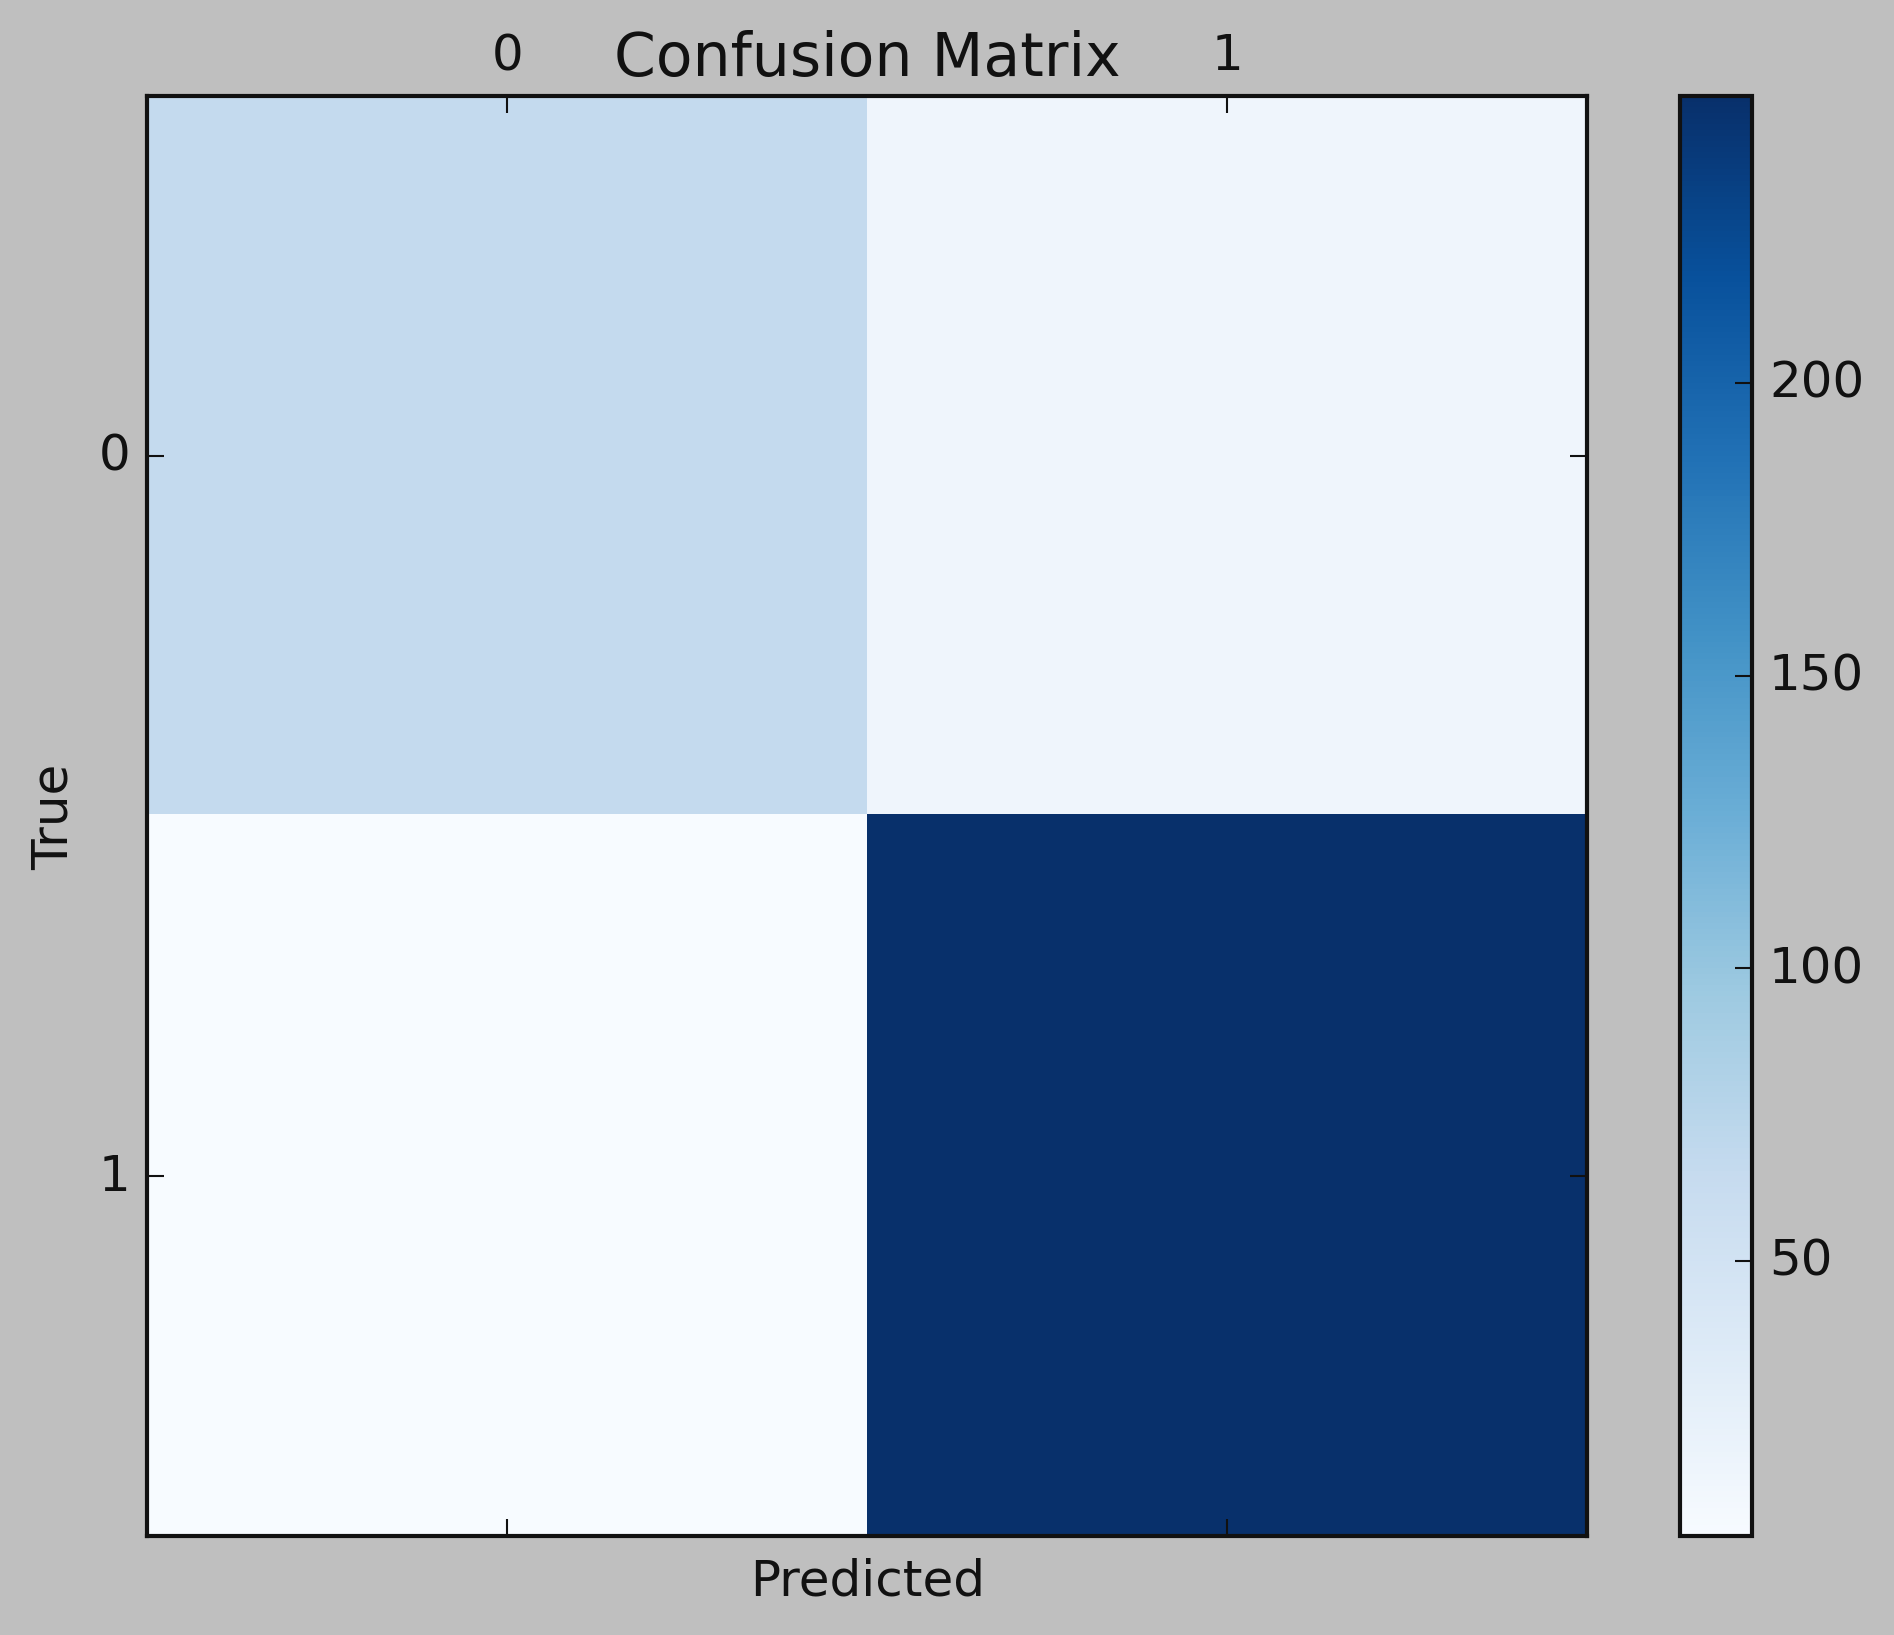

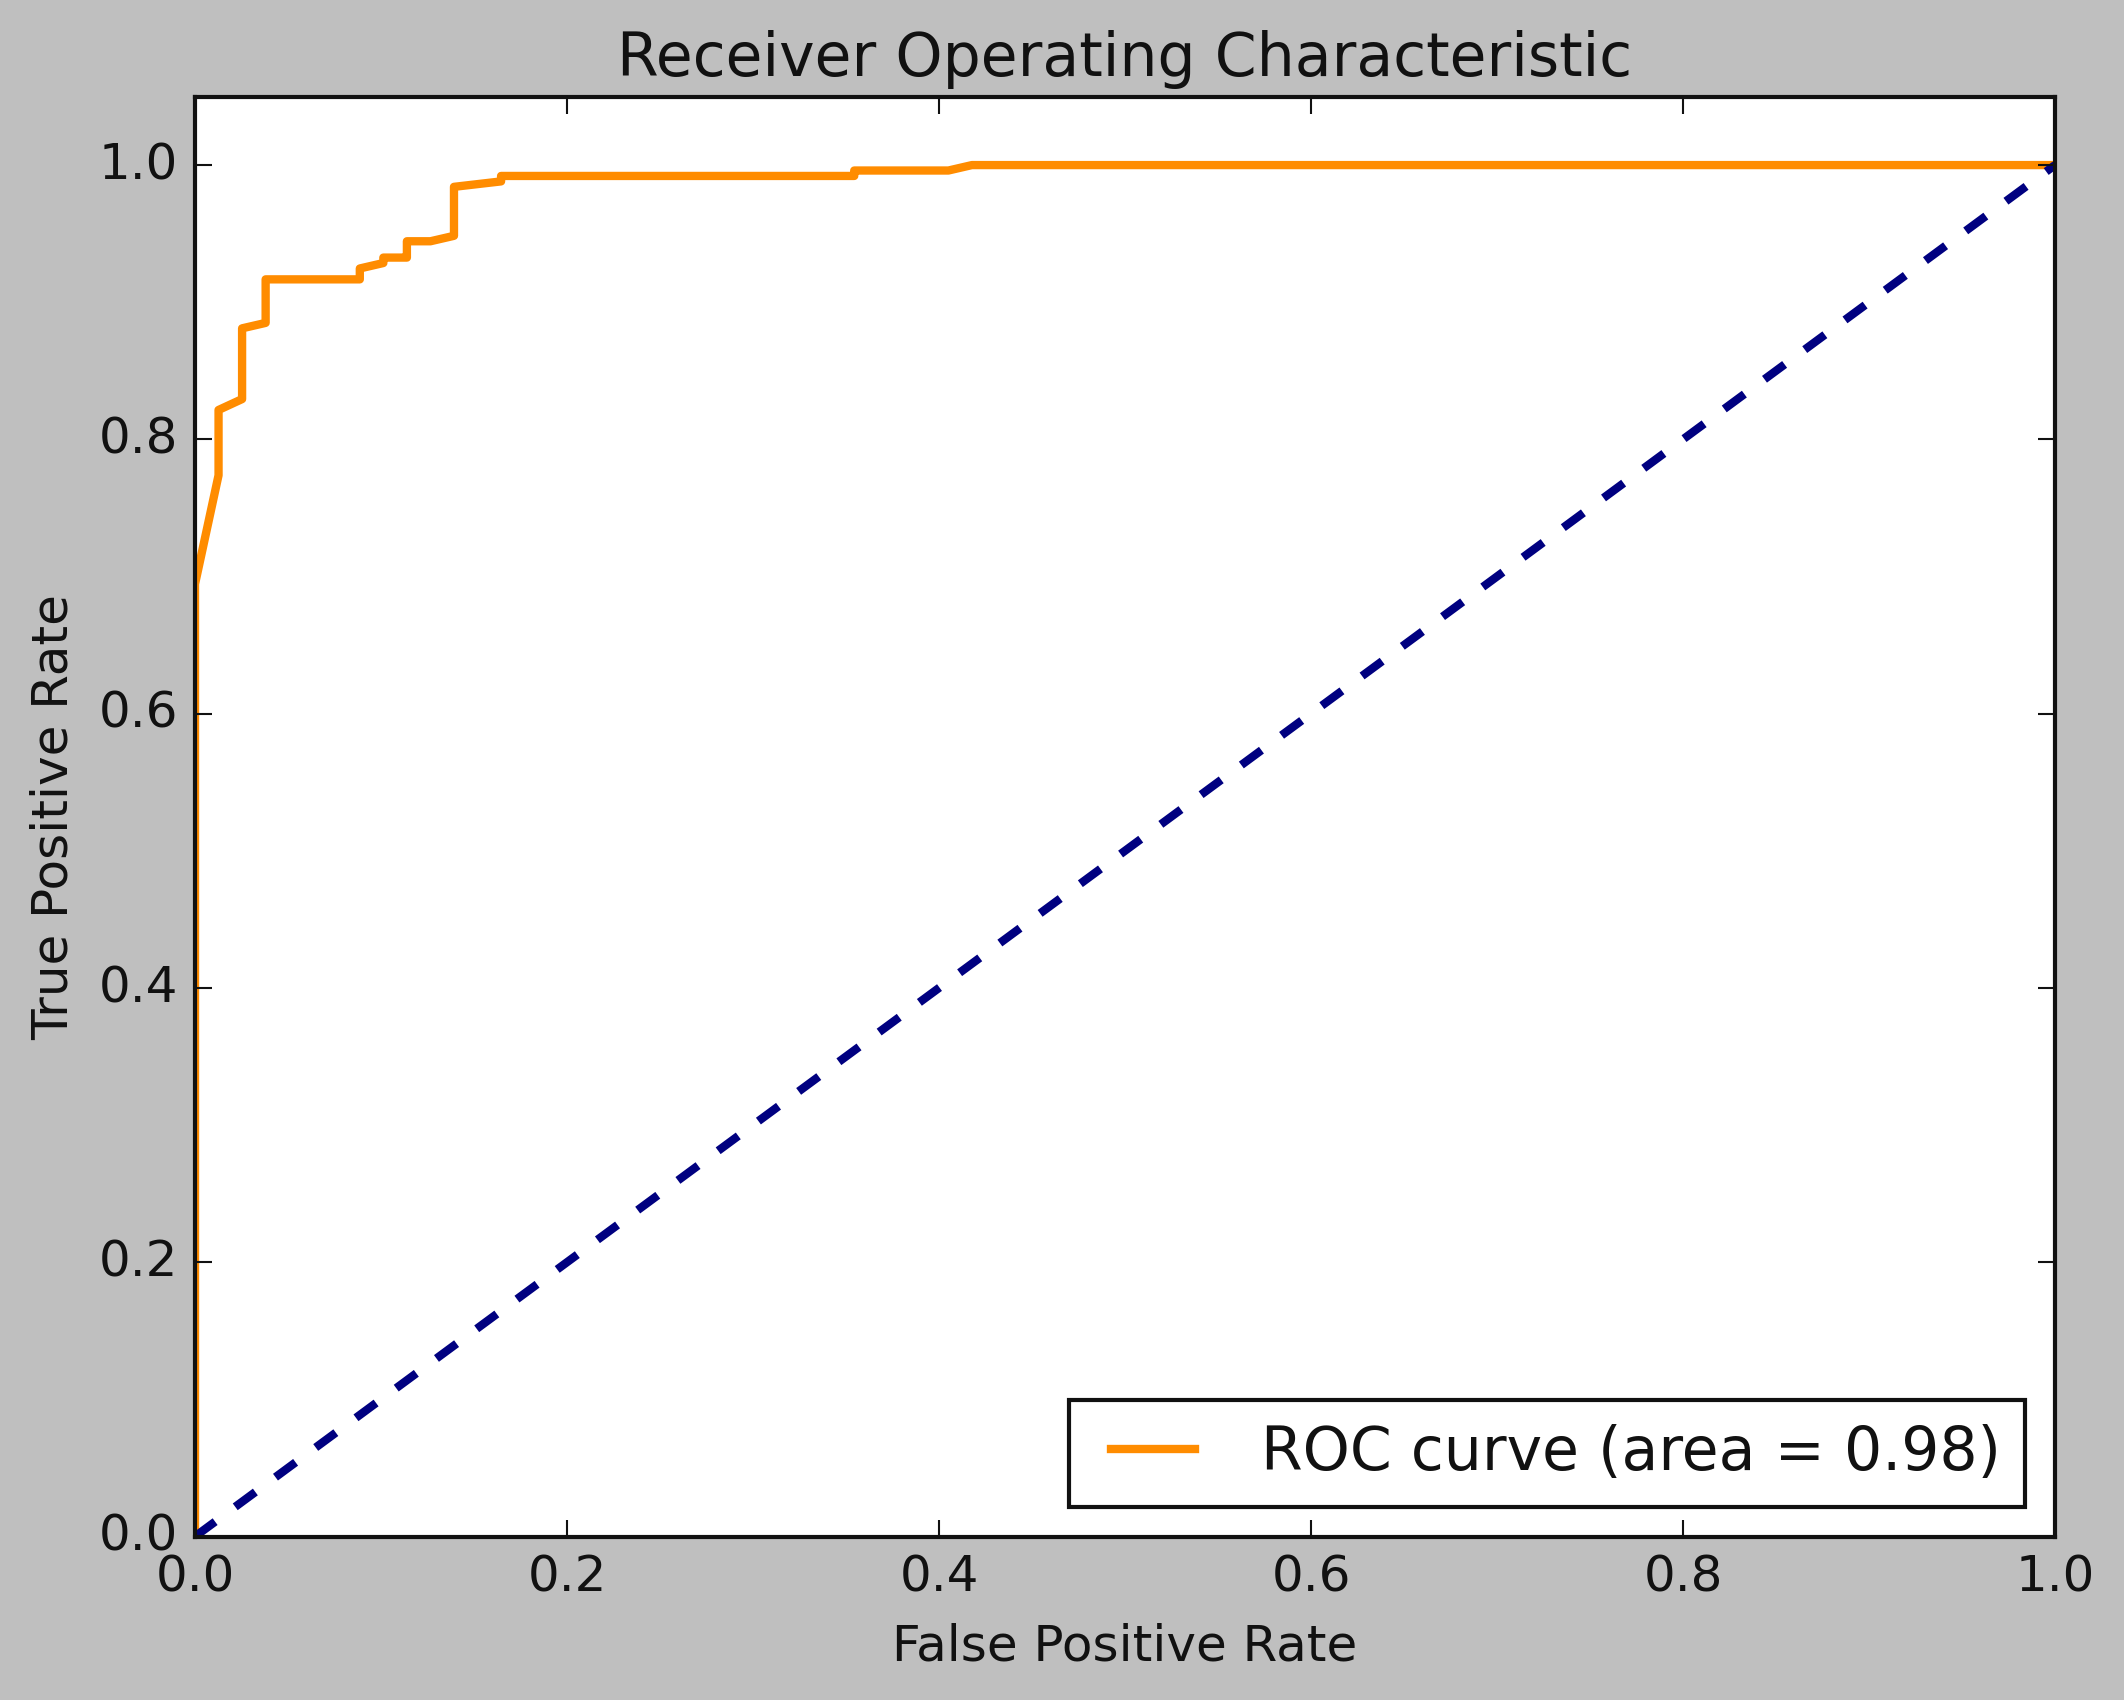

All files processed!


In [ ]:
def predict_file(in_df, name):
    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100)

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Assume 'Abundance' column has been preprocessed to be suitable for classification
    y_label = df['binary_target'].astype(int)

    # Remove unnecessary columns
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # List of features for RFC model
    selected_features = df.columns.tolist()
    print(selected_features)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.1, stratify=y_label, random_state=42)

    # Train the classifier
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # Necessary for AUROC

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_label)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    if len(np.unique(y_label)) == 2:  # Binary classification
        auroc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:  # Multi-class classification
        auroc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Metrics_{name}.xlsx', index=False)

# Sample usage within the multi-threaded context
threads = []
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'

for file in files:  # Loop through the filtered list
    if file.endswith('.xlsx'):  # This check might be redundant since all files in 'files' should end with '.xlsx' based on your conditions above
        print(file)
        file_path = os.path.join(input_directory, file)
        name = os.path.basename(file_path).rsplit('.', 1)[0]

        # Create a thread to process each file
        thread = threading.Thread(target=predict_file, args=(file_path, name))
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")


In [ ]:
def predict_file(in_df, name):
    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100)

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Assume 'Abundance' column has been preprocessed to be suitable for classification
    y_label = df['binary_target'].astype(int)

    # Remove unnecessary columns
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # List of features for RFC model
    selected_features = df.columns.tolist()
    print(selected_features)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.1, stratify=y_label, random_state=42)

    # Train the classifier
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # Necessary for AUROC

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_label)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Confusion Matrix with labels and greyscale
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Greys')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.grid(False)

    # Annotate the plot with labels
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > np.max(cm) / 2 else "black"
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color=text_color, fontsize=20)

    # Define class labels
    class_names = ['Negative', 'Positive']
    tick_marks = np.arange(len(class_names))

    # Add labels to x and y axes
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()

    # Feature Importance Plot
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.barh(df.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for RFC Model')
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}.png')
    plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Metrics_{name}.xlsx', index=False)

# Sample usage within the multi-threaded context
threads = []
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'

for file in files:  # Loop through the filtered list
    if file.endswith('.xlsx'):  # This check might be redundant since all files in 'files' should end with '.xlsx' based on your conditions above
        print(file)
        file_path = os.path.join(input_directory, file)
        name = os.path.basename(file_path).rsplit('.', 1)[0]

        # Create a thread to process each file
        thread = threading.Thread(target=predict_file, args=(file_path, name))
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")

df_Bov Swiss Intensity
0    0.956057
1    5.401111
2   -2.749181
3    6.031074
4   -3.042108
Name: Enrich, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: binary_target, dtype: int64
Best Features Names: ['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'molecular_weight', 'flexibility_min', 'gravy', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_Ligand', 'Dtem', 'Dh_functionalized', 'NP_incubation Concentration (mg/mL)', 'Incubation Concentration (mg/ml)']
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R'

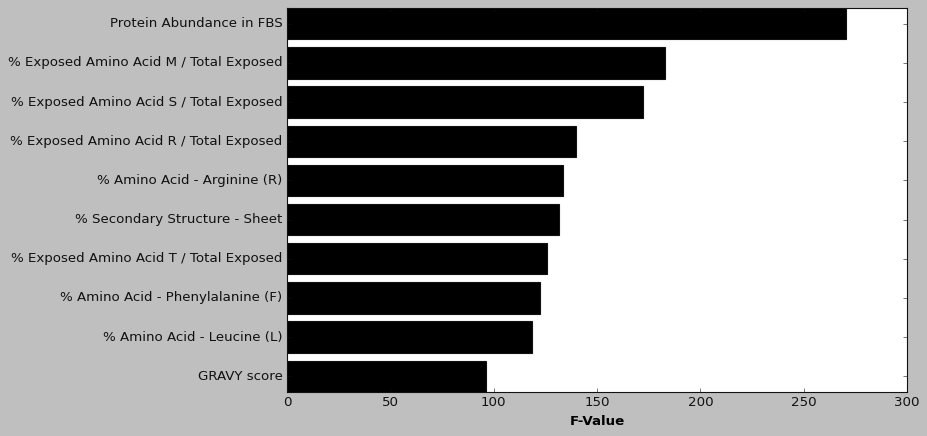

                                   Feature     F-Value       P-Value
0                 Protein Abundance in FBS  270.299745  1.938340e-58
16  % Exposed Amino Acid M / Total Exposed  183.103049  1.212909e-40
19  % Exposed Amino Acid S / Total Exposed  172.121907  2.286290e-38
18  % Exposed Amino Acid R / Total Exposed  139.581323  1.410621e-31
7              % Amino Acid - Arginine (R)  133.614495  2.526684e-30
22           % Secondary Structure - Sheet  131.401825  7.377445e-30
20  % Exposed Amino Acid T / Total Exposed  125.751756  1.142410e-28
3         % Amino Acid - Phenylalanine (F)  122.263971  6.216402e-28
5               % Amino Acid - Leucine (L)  118.483358  3.908952e-27
10                             GRAVY score   96.364320  1.933538e-22


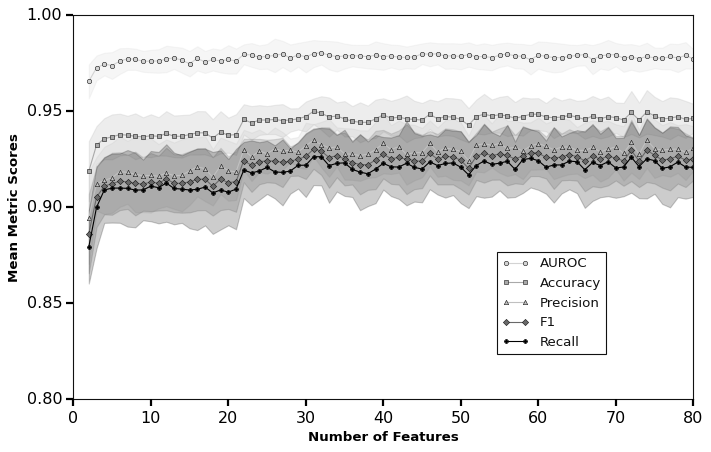

All files processed!


In [ ]:
# Function to be run in each thread
def process_file(in_df, name):
    # Enrichment threshold for binary classification
    thresh = 1

    # Read the input DataFrame
    df = pd.read_excel(in_df, header=0)
    #df_original = df.copy()  # Save a copy of the original DataFrame for later use

    # Find the second-smallest value in 'Abundance_Controls' column
    Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

    # Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
    df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
    print(df['Enrich'].head())

    # Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
    df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
    print(df['binary_target'].head())

    # Copy 'binary_target' column as the y_label (target value) DataFrame
    #y_label = df['binary_target'].copy().values
    label_df = df['binary_target'].copy()

    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in df.columns]
    df_original = df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of fold for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = df.shape[1]
    min_features = 1

    selected_features = None
    current_score = float(-1)

    # naming change 9/1
    # df_full_results = pd.DataFrame({"Number of features": [],
    #                                 "Avg accuracy": [],
    #                                 "Accuracy std": [],
    #                                 "Avg precision": [],
    #                                 "Precision std": [],
    #                                 "Avg recall": [],
    #                                 "Recall std": [],
    #                                 "Avg f1": [],
    #                                 "F1 std": [],
    #                                 "Avg AUROC": [],
    #                                 "AUROC std": [],
    #                                 "List of features": [],
    #                                 "Combined Score": []}
    #                                )

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Accuracy": [],
                                    "Accuracy std": [],
                                    "Precision": [],
                                    "Precision std": [],
                                    "Recall": [],
                                    "Recall std": [],
                                    "F1": [],
                                    "F1 std": [],
                                    "AUROC": [],
                                    "AUROC std": [],
                                    "List of features": [],
                                    "Combined Score": []}
                                   )

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies, precisions, recalls, f1s, aurocs = [], [], [], [], []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in df.columns}

        for train_index, test_index in kf.split(df):
            X_train, X_test = df.iloc[train_index], df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

          # Evaluate on validation set
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Record the results
        # naming change 9/1
        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        # df_full_results.loc[len(df_full_results)] = {
        #     'Number of features': n_features,
        #     'Avg accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
        #     'Avg precision': avg_precision, 'Precision std': std_precision,
        #     'Avg recall': avg_recall, 'Recall std': std_recall,
        #     'Avg f1': avg_f1, 'F1 std': std_f1,
        #     'Avg AUROC': avg_auroc, 'AUROC std': std_auroc,
        #     'List of features': ", ".join(df.columns),
        #     'Combined Score': avg_accuracy - std_accuracy - (n_features / 5000)
        # }

        df_full_results.loc[len(df_full_results)] = {
            'Number of features': n_features,
            'Accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
            'Precision': avg_precision, 'Precision std': std_precision,
            'Recall': avg_recall, 'Recall std': std_recall,
            'F1': avg_f1, 'F1 std': std_f1,
            'AUROC': avg_auroc, 'AUROC std': std_auroc,
            'List of features': ", ".join(df.columns),
            'Combined Score': avg_accuracy - std_accuracy - (n_features / 5000)
        }

        # Drop the feature with the lowest importance sum
        df = df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            # Selecting the best features of the current df
            best_features = df.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_RFC_results_{name}_{identifier}_v2.csv', index=False)
    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)
    feats.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feats_RFECV_RFC_{name}_{identifier}_v2.xlsx', index=False)
    #RFC_Scores.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Scores_RFECV_RFC_{name}_{identifier}_v2.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/df_RFECV_RFC_{name}_{identifier}_v2.xlsx', index=False)

    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Rank features by ANOVA
    ranked_features = rank_features_by_anova(df_best[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)

    # Save the ranked features to a CSV file
    top_10_features.to_csv(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/ANOVA_top_features_{name}_v2')

    # Plot top features
    plot_top_features(top_10_features, name)  # This is the specific line where the function is called

    print(top_10_features)

    # # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Ensure df_full_results is already defined and filled with the necessary data
    # metrics = ['Avg accuracy', 'Avg precision', 'Avg recall', 'Avg f1', 'Avg AUROC']
    # std_metrics = ['Accuracy std', 'Precision std', 'Recall std', 'F1 std', 'AUROC std']
    metrics = ['AUROC', 'Accuracy', 'Precision', 'F1', 'Recall']
    std_metrics = ['AUROC std', 'Accuracy std', 'Precision std', 'F1 std', 'Recall std']

    # Colors for each model evaluation metric line in plot
    colors = ['lightgrey', 'darkgrey', 'silver', 'dimgray', 'black']

    # Define different markers for each metric
    markers = ['o', 's', '^', 'D', 'P']


    for metric, std, color, marker in zip(metrics, std_metrics, colors, markers):
        mean_values = df_full_results[metric].values
        std_devs = df_full_results[std].values
        n_features = df_full_results['Number of features'].values

        ax.plot(n_features, mean_values, label=metric, color=color, marker=marker, markersize=4)
        ax.fill_between(n_features, mean_values - std_devs, mean_values + std_devs, color=color, alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Mean Metric Scores', fontweight='bold', color='black')
    ax.set_ylim([0.80, 1.00])
    plt.xlim(left=0, right=80) # changed from 83 to 80 to improve graphics
    #ax.set_title(f'RFC Model: RFECV Results for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    ax.legend(loc='lower right', fontsize='medium', bbox_to_anchor=(0.87, 0.1), borderaxespad=0.5, frameon=True)

    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/RFECV_plot_{name}_v2.png')
    plt.show()
    plt.close()


# Initialize an empty list to store threads
#threads = []

# Iterate over the files in the directory
for file in os.listdir(input_directory):
    if file.endswith('.xlsx') and file in files:
        # Get the full path of the Excel file
        file_path = os.path.join(input_directory, file)

        # Isolate the name by splitting the path and extracting the last part without the file extension
        name = os.path.basename(file_path).rsplit('.', 1)[0]
        print(name)

        process_file(file_path, name)


        # Create a thread that runs process_file on each Excel file
        #thread = threading.Thread(target=process_file, args=(file_path, name))

        # Append the thread to the list and start it
        #threads.append(thread)
        #thread.start()

# Wait for all threads to complete
#for thread in threads:
    #thread.join()

print("All files processed!")

df_RFECV_RFC_df_Bov Swiss Intensity_accuracy.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_F', 'frac_aa_G', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'molecular_weight', 'flexibility_min', 'gravy', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_Ligand', 'Dtem', 'Dh_functionalized', 'NP_incubation Concentration (mg/mL)', 'Incubation Concentration (mg/ml)']
Accuracy: 0.9516616314199395
Precision: 0.94443559520017
Recall: 0.9204591119148081
F1 Score: 0.9316821465428277
AUROC: 0.9825195901145268


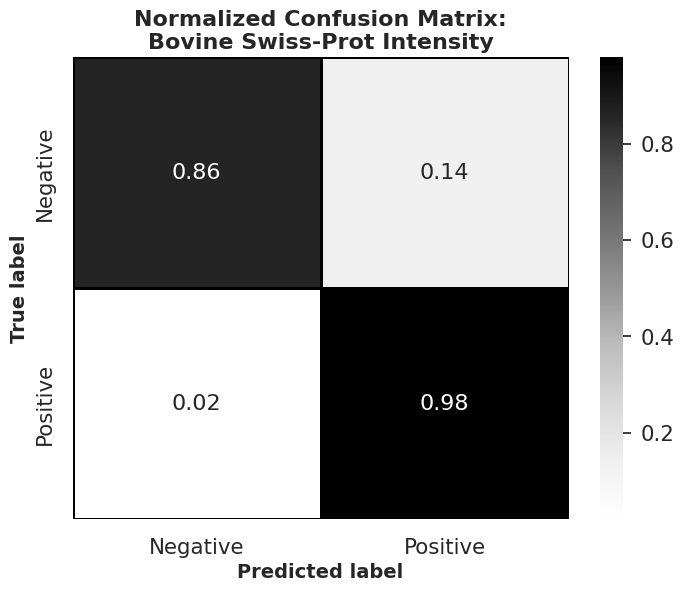

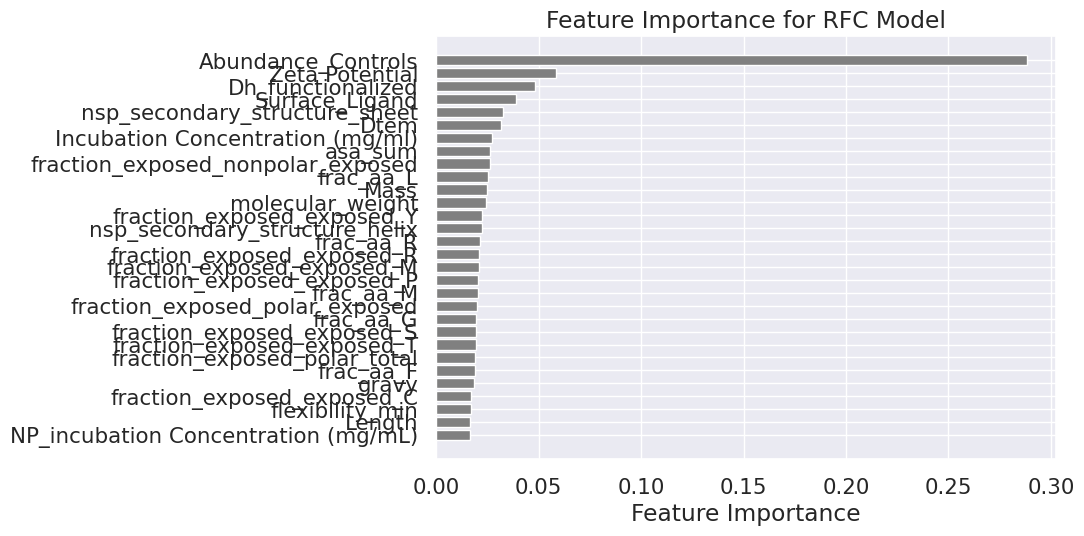

All files processed!


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.title('Normalized Confusion Matrix:\nBovine Swiss-Prot Intensity', fontweight='bold', fontsize=16)
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()

def predict_file(in_df, name):
    model = RandomForestClassifier(n_estimators=100)
    df = pd.read_excel(in_df, header=0)
    df_original = df.copy()

    y_label = df['binary_target'].astype(int)
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    selected_features = df.columns.tolist()
    print(selected_features)

    X_train, X_test, y_train, y_test = train_test_split(df, y_label, test_size=0.1, stratify=y_label, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_label)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Call the new function to plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Feature Importance Plot
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.barh(df.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for RFC Model')
    plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}.png')
    plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Metrics_{name}.xlsx', index=False)



# Sample usage within the multi-threaded context
threads = []
#change input directory based on which file type being run
input_directory = '/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity'

for file in files:  # Loop through the filtered list
    if file.endswith('.xlsx'):  # This check might be redundant since all files in 'files' should end with '.xlsx' based on your conditions above
        print(file)
        file_path = os.path.join(input_directory, file)
        name = os.path.basename(file_path).rsplit('.', 1)[0]

        # Create a thread to process each file
        thread = threading.Thread(target=predict_file, args=(file_path, name))
        threads.append(thread)
        thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All files processed!")
